In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import scirpy as ir
import decoupler as dc
# import scrublet as scr
import muon as mu
#from vpolo.alevin import parser # to parse alevin output
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.multitest as multi
from adjustText import adjust_text
import re

seed = 0
np.random.seed(seed)
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

2025-01-06 14:10:52.559124: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 14:10:53.354152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-06 14:10:53.732587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-06 14:10:53.843914: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 14:10:54.529331: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False, frameon=False)  # low dpi (dots per inch) yields small inline figures

import matplotlib as mpl
# 2 lines below solved the facecolor problem.
# mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
sc.settings.autosave = True
sc.logging.print_header()

version = '241212_BLD_VDJ'
# input_table = '../data/231009_PBMC_HH514.csv'

results_file = '../scanpy/{}/res.h5ad'.format(version)
results_file_mu = '../scanpy/{}/res.h5mu'.format(version)
results_file_cellxgene = '../scanpy/{}/res.cxg.h5ad'.format(version)

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)

sc.settings.figdir = '../scanpy/{}/graph'.format(version)
sc.settings.cachedir = '../scanpy/{}/cache'.format(version)
# %config InlineBackend.figure_format = 'retina'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)
os.makedirs(sc.settings.figdir, exist_ok=True)

scanpy==1.10.2 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.0.3 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
adata = sc.read('/home/yy693/pi_hafler/ASAP/scanpy/241028_BLD_downstream/res.h5ad')
# adata.obs['Hyposmia'] = adata.obs['UPSITPercentile'] <= 15
# adata.obs['Diagnosis_RBDstrat'] = adata.obs['EnrollmentCategory'].astype(str)
# # adata.obs['Diagnosis_RBDstrat'] + '_' + adata.obs['Hyposmia'].astype(str)
# adata.obs.loc[(adata.obs['EnrollmentCategory'] == 'RBD') & (adata.obs['Hyposmia']), 'Diagnosis_RBDstrat'] = 'RBD_Hyposmia_pos'
# adata.obs.loc[(adata.obs['EnrollmentCategory'] == 'RBD') & (~ adata.obs['Hyposmia']), 'Diagnosis_RBDstrat'] = 'RBD_Hyposmia_neg'

In [4]:
adata

AnnData object with n_obs × n_vars = 523521 × 26640
    obs: 'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Year1stDLBSx', 'YearDLBDX', 'DLB

In [5]:
f_file_list = '/home/yy693/pi_hafler/ASAP/data/250106_cellranger_files_VDJ.csv'


df_file = pd.read_csv(f_file_list)
df_file = df_file[df_file['SampleType'] == 'BLD']

In [6]:
df_file

path  \
0    /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
1    /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
4    /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
5    /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
8    /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
..                                                 ...   
290  /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
293  /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
294  /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
297  /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
298  /home/yy693/pi_hafler/ASAP/output/cellranger/2...   

                                directory   cellranger_sample_id   SampleID  \
0                      20220523_lz438_vdj  YPD001BLD_BCR_VHT_VDJ  YPD001BLD   
1                      20220523_lz438_vdj  YPD001BLD_TCR_VHT_VDJ  YPD001BLD   
4                      20220523_lz438_vdj  YPD002BLD_BCR_VHT_VDJ  YPD002BLD   
5                      20220523_lz438_vdj  YPD002BLD_TCR_VHT_VDJ  YPD002BLD   
8                      20220523_lz438_vdj  YPD003BLD_BCR_VHT_VDJ  YPD003BLD   
..                                    ...                    ...        ...   
290  20250102_lz438_22G52FLT4_RQ32646_vdj  YPD093BLD_TCR_VHT_VDJ  YPD093BLD   
293  20250102_lz438_22G52FLT4_RQ32646_vdj  YPD096BLD_BCR_VHT_VDJ  YPD096BLD   
294  20250102_lz438_22G52FLT4_RQ32646_vdj  YPD096BLD_TCR_VHT_VDJ  YPD096BLD   
297  20250102_lz438_22G52FLT4_RQ32646_vdj  YPD097BLD_BCR_VHT_VDJ  YPD097BLD   
298  20250102_lz438_22G52FLT4_RQ32646_vdj  YPD097BLD_TCR_VHT_VDJ  YPD097BLD   

    experiment SampleType DonorID vdj_type Estimated Number of Cells  \
0          VDJ        BLD  YPD001      BCR                       502   
1          VDJ        BLD  YPD001      TCR                     2,579   
4          VDJ        BLD  YPD002      BCR                        15   
5          VDJ        BLD  YPD002      TCR                     5,959   
8          VDJ        BLD  YPD003      BCR                       650   
..         ...        ...     ...      ...                       ...   
290        VDJ        BLD  YPD093      TCR                     4,314   
293        VDJ        BLD  YPD096      BCR                       543   
294        VDJ        BLD  YPD096      TCR                       748   
297        VDJ        BLD  YPD097      BCR                       652   
298        VDJ        BLD  YPD097      TCR                     6,029   

    Mean Read Pairs per Cell  ...  \
0                    132,667  ...   
1                     25,569  ...   
4                  4,779,547  ...   
5                     14,249  ...   
8                    101,483  ...   
..                       ...  ...   
290                   24,940  ...   
293                  175,392  ...   
294                  135,649  ...   
297                  198,377  ...   
298                   14,747  ...   

    Cells With Productive V-J Spanning (TRA, TRB) Pair Cells With TRA Contig  \
0                                                  NaN                   NaN   
1                                                86.3%                 96.4%   
4                                                  NaN                   NaN   
5                                                83.7%                 91.0%   
8                                                  NaN                   NaN   
..                                                 ...                   ...   
290                                              83.2%                 90.0%   
293                                                NaN                   NaN   
294                                              75.4%                 86.6%   
297                                                NaN                   NaN   
298                                              85.6%                 92.0%   

    Cells With TRB Contig Cells With CDR3-annotated TRA Contig  \
0                     NaN                                  NaN   
1

In [ ]:
df_file.iloc[0].path

'/home/yy693/pi_hafler/ASAP/output/cellranger/20220523_lz438_vdj/YPD001BLD_BCR_VHT_VDJ/outs'

In [8]:
list_cols = ['cellranger_sample_id', 'SampleID', 
       'SampleType', 'DonorID']
       
dict_adata_tcr = {}
for pos,row in df_file[df_file['vdj_type']=='TCR'].iterrows():
    a = ir.io.read_airr(f"{row['path']}/airr_rearrangement.tsv")
    a.var_names_make_unique()
    for col in list_cols:
        a.obs[col] = row[col]

    # sc.pp.scrublet(a, expected_doublet_rate=doublet_rate(a.shape[0], row['chemistry']))

    dict_adata_tcr[row['SampleID']] = a

adata_tcr = sc.concat(dict_adata_tcr, join='outer', index_unique='-')

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/utils.py:346: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/utils.py:346: ExperimentalFeatureWarning: Outer joins on awkward.Arrays will have different return values in the future. For details, and to offer input, please see:

	https://github.com/scverse/anndata/issues/898
  warnings.warn(msg, category, stacklevel=stacklevel)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
adata_tcr.obs

cellranger_sample_id   SampleID SampleType  \
cell_id                                                                     
AAACCTGAGTCCCACG-1-YPD001BLD  YPD001BLD_TCR_VHT_VDJ  YPD001BLD        BLD   
AAACCTGCACGAGAGT-1-YPD001BLD  YPD001BLD_TCR_VHT_VDJ  YPD001BLD        BLD   
AAACCTGGTGAAGGCT-1-YPD001BLD  YPD001BLD_TCR_VHT_VDJ  YPD001BLD        BLD   
AAACGGGAGATCACGG-1-YPD001BLD  YPD001BLD_TCR_VHT_VDJ  YPD001BLD        BLD   
AAACGGGCAAGAGGCT-1-YPD001BLD  YPD001BLD_TCR_VHT_VDJ  YPD001BLD        BLD   
...                                             ...        ...        ...   
TTTGTCAGTATTCGTG-1-YPD097BLD  YPD097BLD_TCR_VHT_VDJ  YPD097BLD        BLD   
TTTGTCAGTCTAGTCA-1-YPD097BLD  YPD097BLD_TCR_VHT_VDJ  YPD097BLD        BLD   
TTTGTCAGTGGTAACG-1-YPD097BLD  YPD097BLD_TCR_VHT_VDJ  YPD097BLD        BLD   
TTTGTCATCGTCCGTT-1-YPD097BLD  YPD097BLD_TCR_VHT_VDJ  YPD097BLD        BLD   
TTTGTCATCTCCGGTT-1-YPD097BLD  YPD097BLD_TCR_VHT_VDJ  YPD097BLD        BLD   

                             DonorID  
cell_id                               
AAACCTGAGTCCCACG-1-YPD001BLD  YPD001  
AAACCTGCACGAGAGT-1-YPD001BLD  YPD001  
AAACCTGGTGAAGGCT-1-YPD001BLD  YPD001  
AAACGGGAGATCACGG-1-YPD001BLD  YPD001  
AAACGGGCAAGAGGCT-1-YPD001BLD  YPD001  
...                              ...  
TTTGTCAGTATTCGTG-1-YPD097BLD  YPD097  
TTTGTCAGTCTAGTCA-1-YPD097BLD  YPD097  
TTTGTCAGTGGTAACG-1-YPD097BLD  YPD097  
TTTGTCATCGTCCGTT-1-YPD097BLD  YPD097  
TTTGTCATCTCCGGTT-1-YPD097BLD  YPD097  

[440773 rows x 4 columns]

In [10]:
dict_adata_bcr = {}
for pos,row in df_file[df_file['vdj_type']=='BCR'].iterrows():
    if int(row['Estimated Number of Cells'].replace(',','')) > 0:
        a = ir.io.read_airr(f"{row['path']}/airr_rearrangement.tsv")
        a.var_names_make_unique()
        for col in list_cols:
            a.obs[col] = row[col]

        # sc.pp.scrublet(a, expected_doublet_rate=doublet_rate(a.shape[0], row['chemistry']))

        dict_adata_bcr[row['SampleID']] = a

adata_bcr = sc.concat(dict_adata_bcr, join='outer', index_unique='-')

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
adata_bcr

AnnData object with n_obs × n_vars = 79414 × 0
    obs: 'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID'
    obsm: 'airr'

In [12]:
ir.pp.index_chains(adata_tcr)
ir.tl.chain_qc(adata_tcr)
adata_tcr = adata_tcr[adata_tcr.obs['receptor_type'] == 'TCR']

ir.pp.index_chains(adata_bcr)
ir.tl.chain_qc(adata_bcr)
adata_bcr = adata_bcr[adata_bcr.obs['receptor_type'] == 'BCR']

Filtering chains...
Indexing VJ chains...


Indexing VDJ chains...
build result array
Stored result in `adata.obs["receptor_type"]`.
Stored result in `adata.obs["receptor_subtype"]`.
Stored result in `adata.obs["chain_pairing"]`.
Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `adata.obs["receptor_type"]`.
Stored result in `adata.obs["receptor_subtype"]`.
Stored result in `adata.obs["chain_pairing"]`.


In [13]:
mdata = mu.MuData({"gex": adata, "tcr": adata_tcr, "bcr": adata_bcr})

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [14]:
mdata

MuData object with n_obs × n_vars = 713062 × 26640
  3 modalities
    gex:	523521 x 26640
      obs:	'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Year1stDLBSx', 'YearDLBDX', 'DLBAAO', 'AgeDLBDx', 'DLBDxtoConsent', 'PSGinEpic?', 'BirthYear', 'MeetsMDSPDCriteria?', 'PSGDate', 'Ethnicity', 'Race', 'RaceOther', 'PDFamilyHx', 'PDFHMother', 'PDFHFather', 'PDFHFullSibs', 'PDFHHalfSibs', 'PDFHMaternalGPs', 'PDFHPaternalGPs', 'PDFHMaternalAuntsorUncles', 'PDFHChildren', 'PDFHOther', 'DLBFamilyHx', 'DLBFHMother', 'DLBFHFather', 'DLBFHFullSibs', 'DLBFHHalfSibs', 'DLBFHMaternalGPs', 'DLBFHPaternalGPs', 'DLBFHMaternalAuntsorUncles', 'DLBFHChildren', 'DLBFHOther', 'MSAFamilyHx', 'MSAFHMother', 'MSAFHFather', 'MSAFHFullSibs', 'MSAFHHalfSibs', 'MSAFHMaternalGPs', 'MSAFHPaternalGPs', 'MSAFHMaternalAuntsorUncles', 'MSAFHChildren', 'MSAFHOther', 'PDRiskPesticideExposure', 'PDRiskOccupationalsolventExposure', 'PDRiskDrinksCaffeinatedBeverages', 'PDRiskSmokerorFormerSmoker', 'PDRiskPhysicallyActive', 'MeanStriatumSBR', 'MeanStriatumSBR%ile', 'Caudate/PutamenRatio', 'AssymetryIndex', 'OrthostaticHypotension?', 'BloodyTap?', 'ClinicalCSFDataObtained?', 'CSFProtein', 'CSFGlucose', 'ClinicalCSFRBC', 'ClinicalCSFTotalNucleatedCells', 'ClinicalCSFGranulocytes', 'ClinicalCSFLymphocytes', 'CSFClinicalMonocytes', 'CSFVolume', 'CSFTotalCells', 'CSFCells/uL', 'CSFNotes', 'CSFSAA', 'UPSITRawScore', 'UPSITPercentile', 'MOCAVisuospatial', 'MOCA2Naming', 'MOCAMemoryTrial1', 'MOCAMemoryTrial2', 'MOCAAttention', 'MOCALanguage', 'MOCAAbstraction', 'MOCADelayedRecall', 'MOCAMemoryIndexScore', 'MOCAOrientation', 'MOCATotal', 'ParisArousalTotal', 'ConstipationCriteriaScore', 'BMSQ1RisingfromChair', 'BMSQ2Handwriting', 'BMSQ3VoiceSofter', 'BMSQ4PoorBalance', 'BMSQ5FeetGettingStuck', 'BMSQ6FaceLessExpressive', 'BMSQ7ArmsorLegsShaking', 'BMSQ8Buttons', 'BMSQ9Shuffling', 'BMSQ10MoveMoreSlowlythanOthersofAge', 'BMSQTotal', 'LRScore', 'ProbableProdromalPD?', 'SCOPATotal', 'SCPOPAManualEntry', 'NMSSTotal', 'MDS-UPDRS1.1cognition', 'MDS-UPDRS1.2Hallucinations', 'MDS-UPDRS1.3Mood', 'MDS-UPDRS1.4Anxiety', 'MDS-UPDRS1.5Apathy', 'MDS-UPDRS1.6DOPADysregulation', 'MDS-UPDRS1.7Sleep', 'MDS-UPDRS1.8DaytimeSleepiness', 'MDS-UPDRS1.9Pain', 'UMD-UPDRS1.10Urological', 'MDS-UPDRS1.11Constipation', 'MDS-UPDRS1.12OrthostaticDizziness', 'MDS-UPDRS1.13Fatigue', 'MDS-UPDRS2.1Speech', 'MDS-UPDRS2.2Drooling', 'MDS-UPDRS2.3Swallowing', 'MDS-UPDRS2.4Eating', 'MDS-UPDRS2.5Dressing', 'MDS-UPDRS2.6Hygeine', 'MDS-UPDRS2.7Handwriting', 'MDS-UPDRS2.8Hobbies', 'MDS-UPDRS2.9TurninginBed', 'MDS-UPDRS2.10Tremor', 'MDS-UPDRS2.11RisingfromChair,Car,Bed', 'MDS-UPDRS2.12Walking', 'MDS-UPDRS2.13FreezingofGait', 'MDS-UPDRSTakingMeds', 'MDS-UPDRS3.1Speech', 'MDS-UPDRS3.2Facies', 'MDS-UPDRS3.3NeckRigidity', 'MDS-UPDRS3.3RUERigidity', 'MDS-UPDRS3.3LUERidigity', 'MDS-UPDRS3.3RLERidigity', 'MDS-UPDRS3.3LLERigidty', 'MDS-UPDRS3.4FingerTapsR', 'MDS-UPDRS3.4FingerTapsL', 'MDS-UPDRS3.5GraspR', 'MDS-UPDRS3.5GraspL', 'MDS-UPDRS3.6RSMR', 'MDS-UPDRS3.6RSML', 'MDS-UPDRS3.7ToeTapR', 'MDS-UPDRS3.7ToeTapL', 'MDS-UPDRS3.8LegAgilityR', 'MDS-UPDRS3.8LegAgilityL', 'MDS-UPDRS3.9RisingFromC

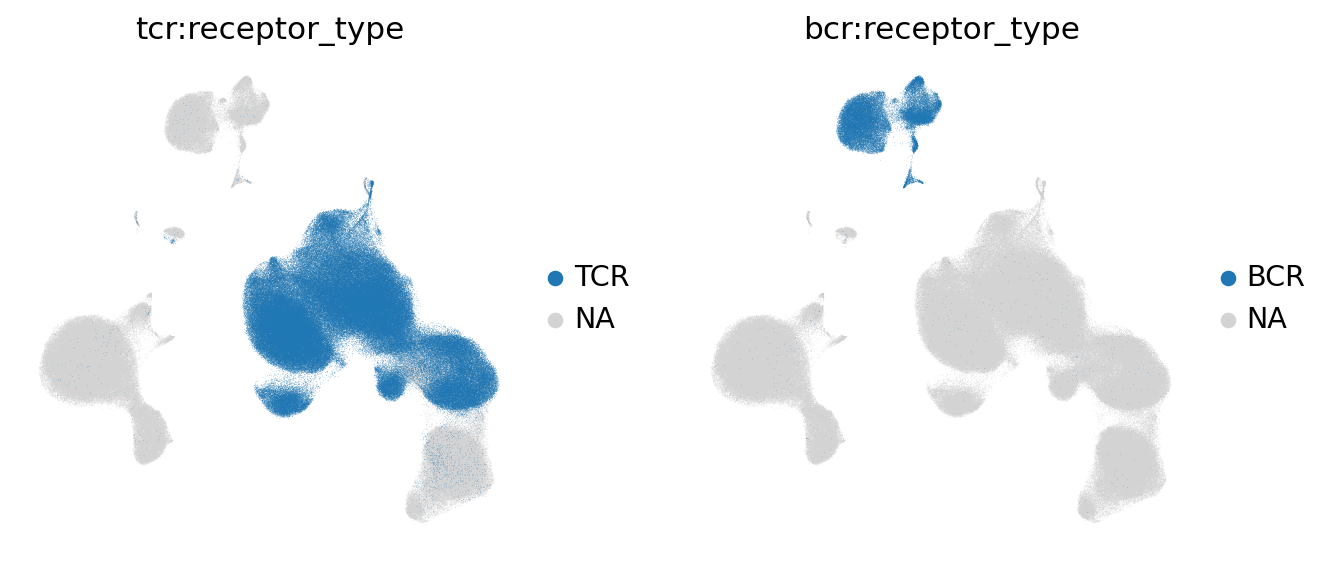

In [15]:
mu.pl.embedding(mdata, basis="gex:umap_filtered", color=["tcr:receptor_type", "bcr:receptor_type"])

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gibbs/project/hafler/yy693/conda

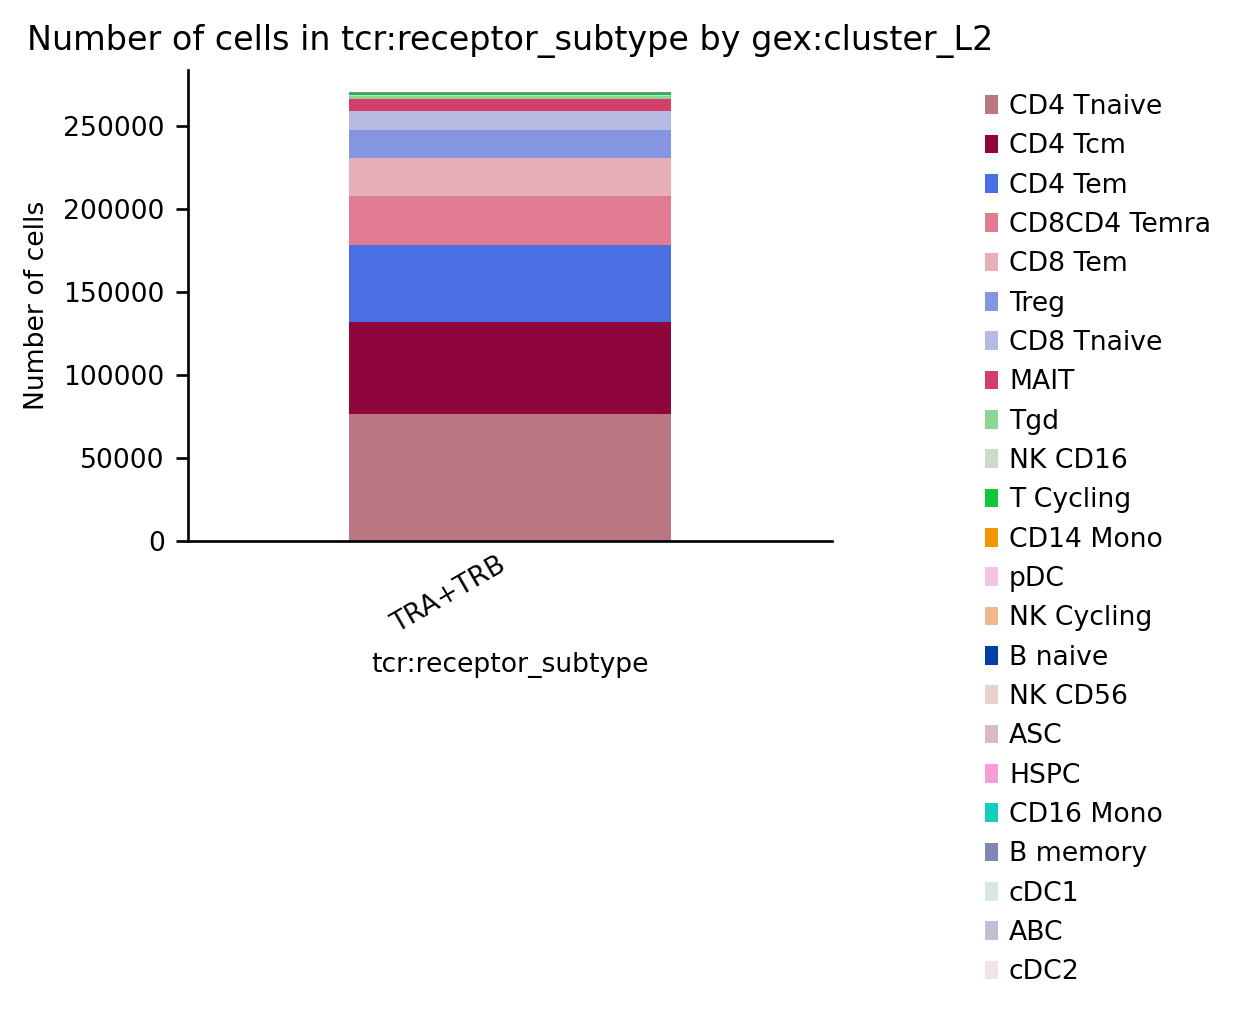

In [16]:
_ = ir.pl.group_abundance(mdata, groupby="tcr:receptor_subtype", target_col="gex:cluster_L2")

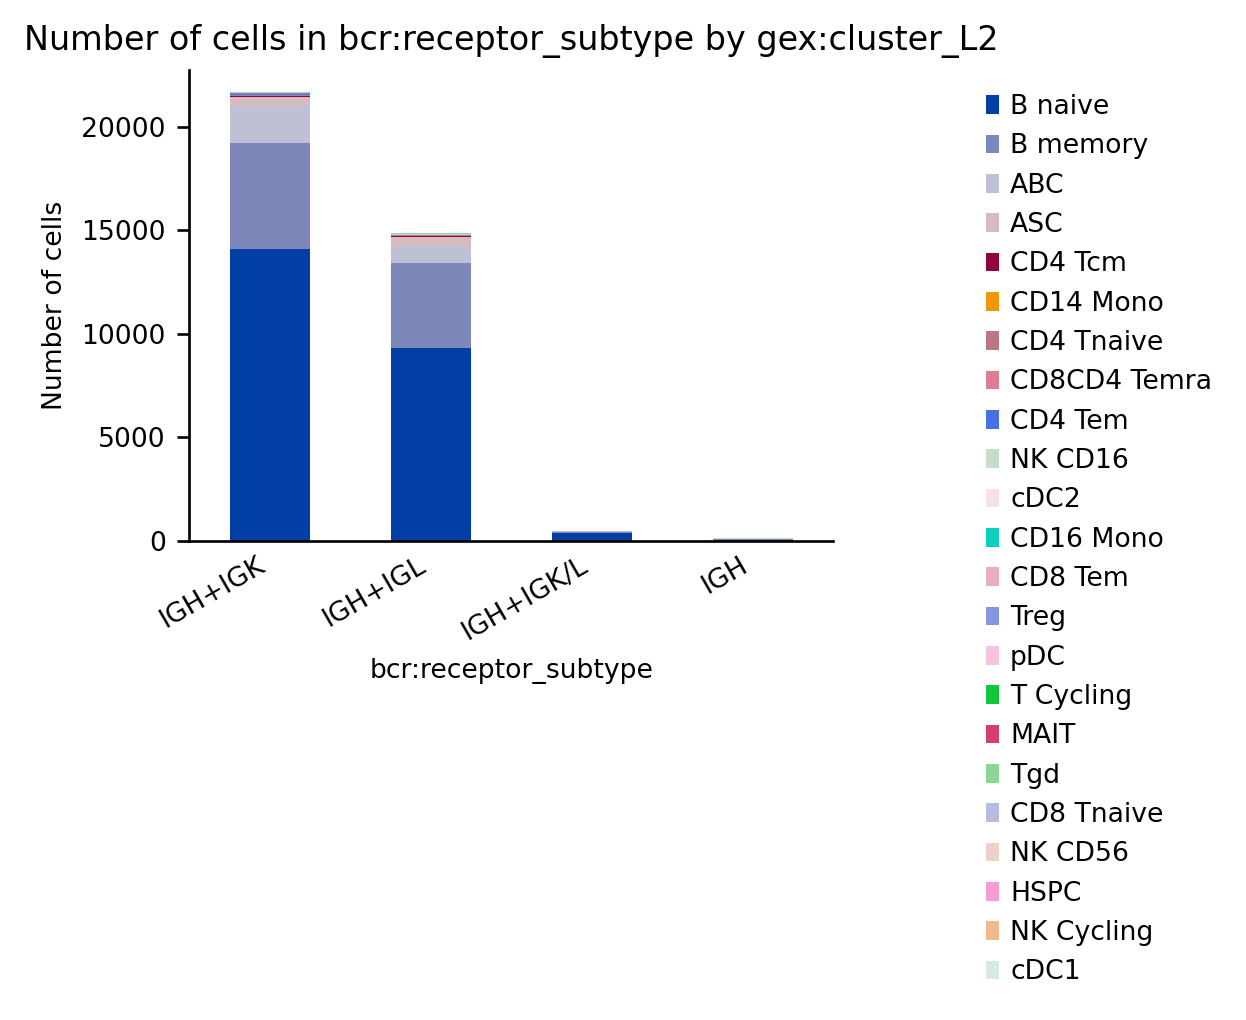

In [17]:
_ = ir.pl.group_abundance(mdata, groupby="bcr:receptor_subtype", target_col="gex:cluster_L2")

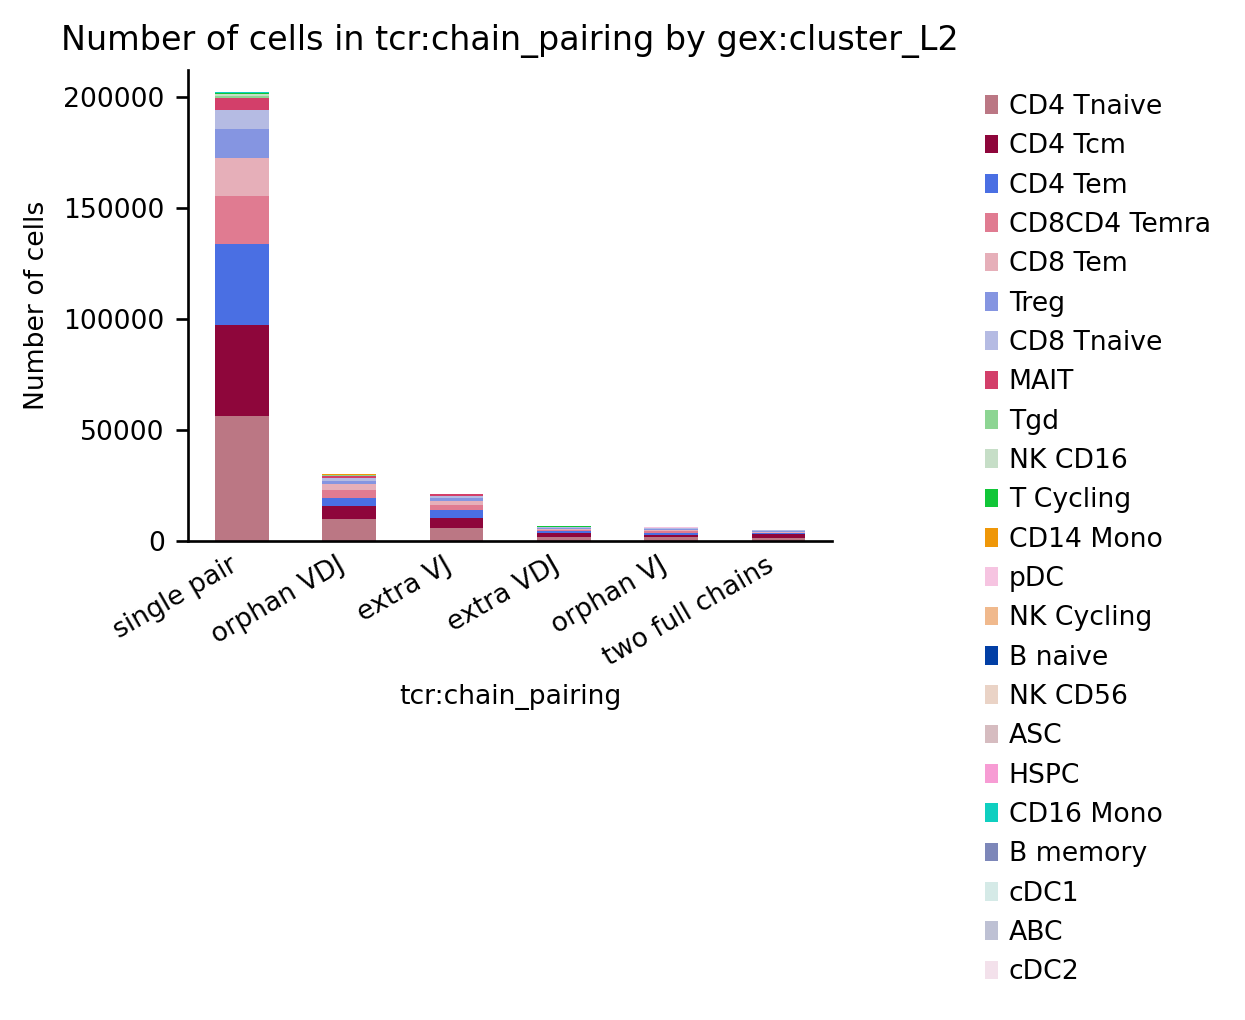

In [18]:
_ = ir.pl.group_abundance(mdata, groupby="tcr:chain_pairing", target_col="gex:cluster_L2")

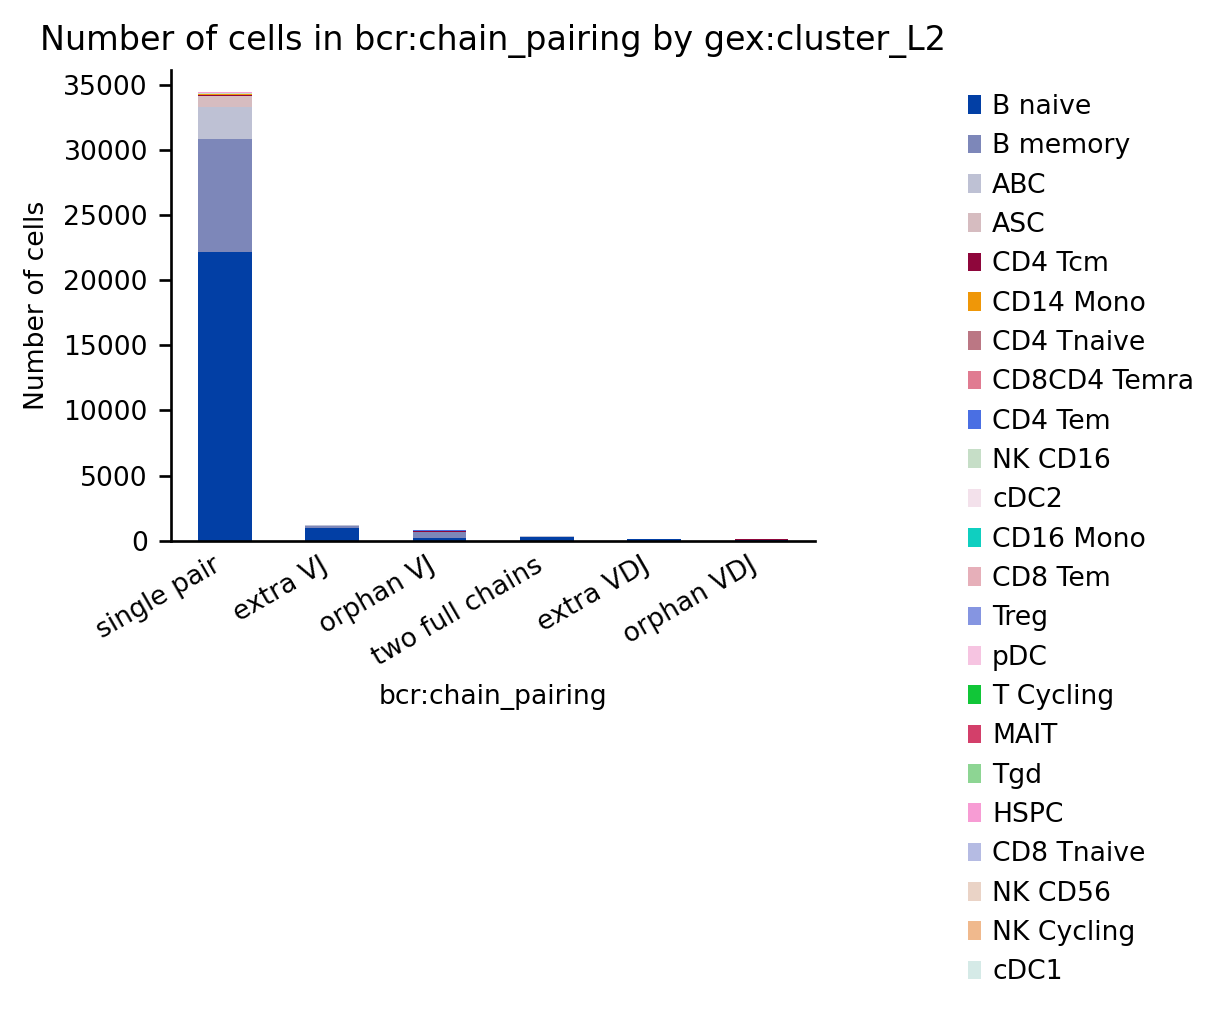

In [19]:
_ = ir.pl.group_abundance(mdata, groupby="bcr:chain_pairing", target_col="gex:cluster_L2")

In [20]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata, airr_mod='tcr')
ir.tl.define_clonotypes(mdata, airr_mod='tcr', receptor_arms="all", dual_ir="primary_only")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:39)
Computing clonotype x clonotype distances.
--> Done computing clonotype x clonotype distances.  (0:00:01)
Stored result in `mdata.obs["tcr:clone_id"]`.
Stored result in `mdata.obs["tcr:clone_id_size"]`.


In [21]:
ir.tl.clonal_expansion(mdata, airr_mod='tcr')

Stored result in `mdata.obs["tcr:clonal_expansion"]`.


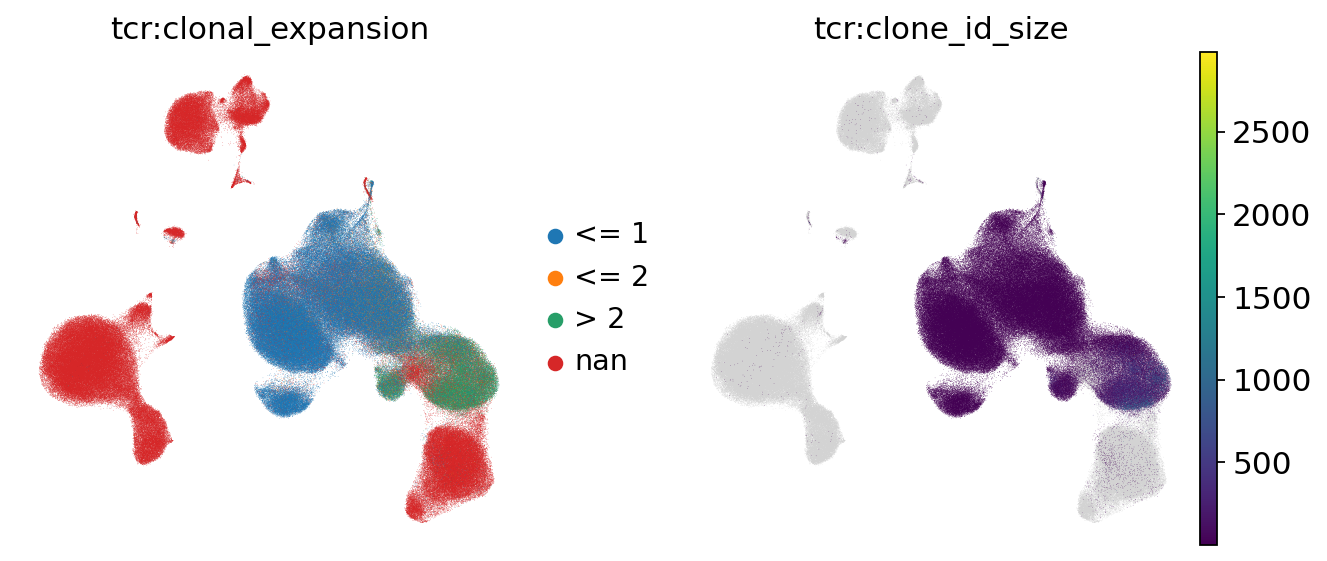

In [22]:
mu.pl.embedding(mdata, basis="gex:umap_filtered", color=["tcr:clonal_expansion", "tcr:clone_id_size"])

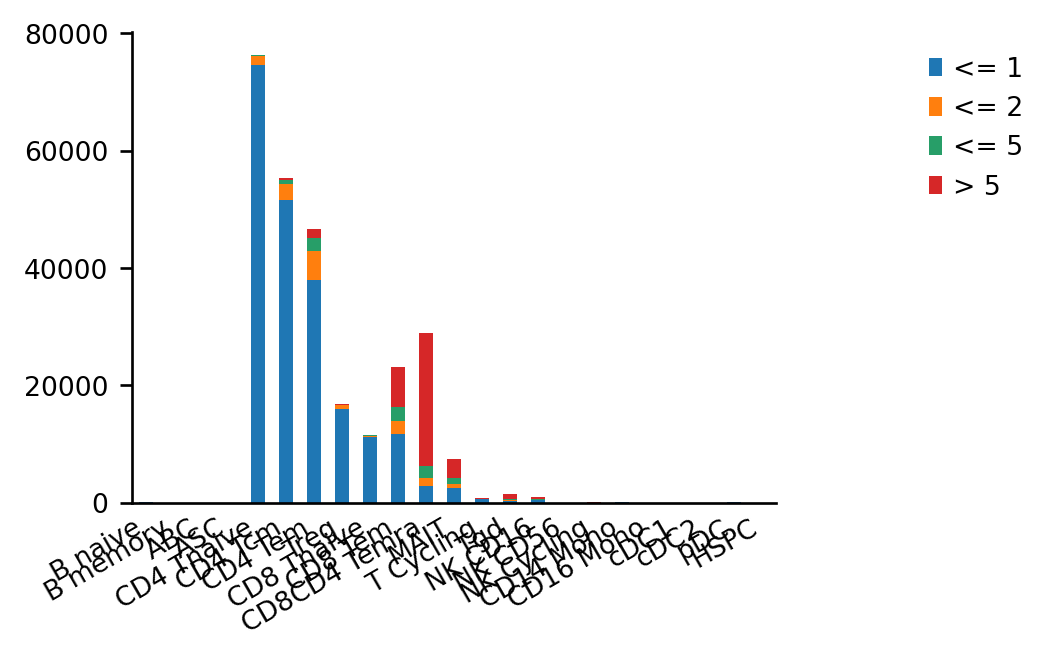

In [23]:
_ = ir.pl.clonal_expansion(mdata, airr_mod='tcr', target_col="clone_id", groupby="gex:cluster_L2", breakpoints=(1, 2, 5), normalize=False)

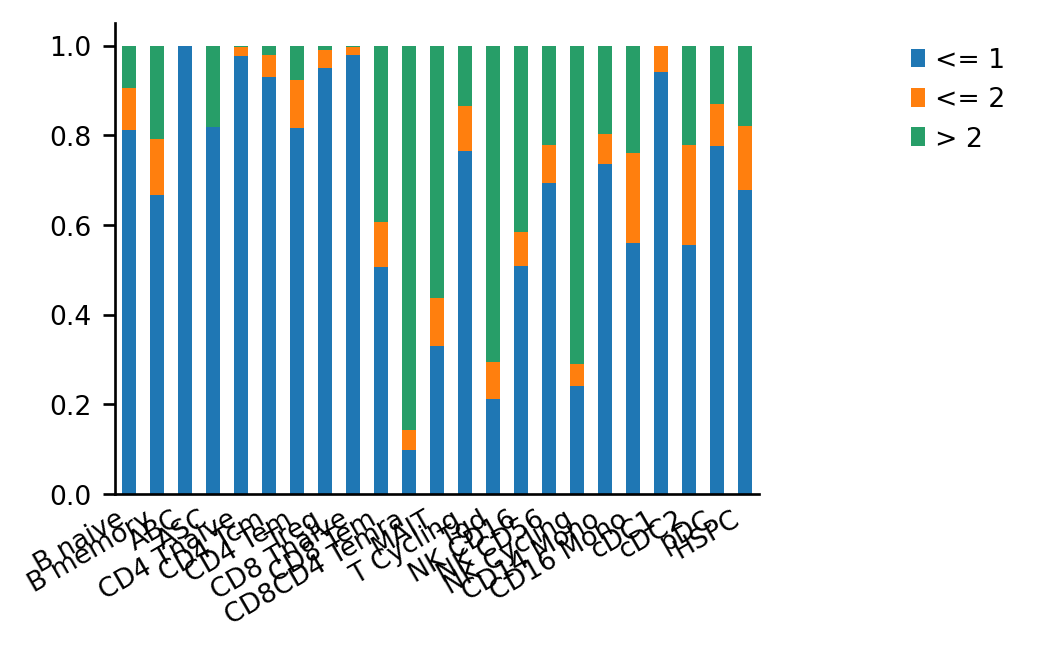

In [24]:
_ = ir.pl.clonal_expansion(
    mdata,
    airr_mod='tcr',
    target_col="clone_id",
    breakpoints=(1, 2),
    groupby="gex:cluster_L2",
    normalize=True,
)

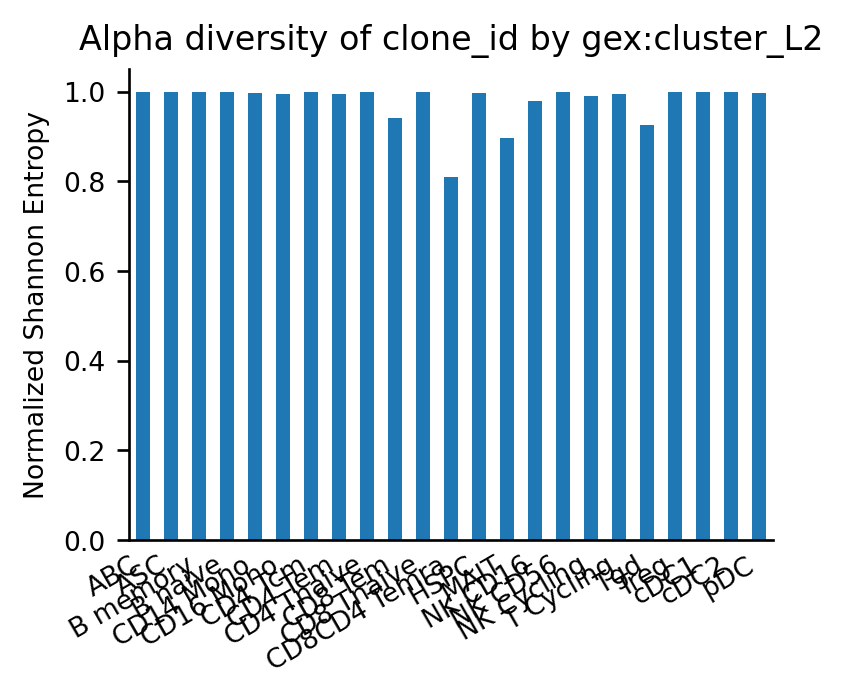

In [25]:
_ = ir.pl.alpha_diversity(mdata, airr_mod='tcr', metric="normalized_shannon_entropy", groupby="gex:cluster_L2")

In [26]:
list_tcell = ['CD8CD4 Temra',
 'CD8 Tem',
 'Treg',
 'CD4 Tcm',
 'CD4 Tem',
 'CD4 Tnaive',
 'CD8 Tnaive']

In [27]:
mdata

MuData object with n_obs × n_vars = 713062 × 26640
  3 modalities
    gex:	523521 x 26640
      obs:	'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Year1stDLBSx', 'YearDLBDX', 'DLBAAO', 'AgeDLBDx', 'DLBDxtoConsent', 'PSGinEpic?', 'BirthYear', 'MeetsMDSPDCriteria?', 'PSGDate', 'Ethnicity', 'Race', 'RaceOther', 'PDFamilyHx', 'PDFHMother', 'PDFHFather', 'PDFHFullSibs', 'PDFHHalfSibs', 'PDFHMaternalGPs', 'PDFHPaternalGPs', 'PDFHMaternalAuntsorUncles', 'PDFHChildren', 'PDFHOther', 'DLBFamilyHx', 'DLBFHMother', 'DLBFHFather', 'DLBFHFullSibs', 'DLBFHHalfSibs', 'DLBFHMaternalGPs', 'DLBFHPaternalGPs', 'DLBFHMaternalAuntsorUncles', 'DLBFHChildren', 'DLBFHOther', 'MSAFamilyHx', 'MSAFHMother', 'MSAFHFather', 'MSAFHFullSibs', 'MSAFHHalfSibs', 'MSAFHMaternalGPs', 'MSAFHPaternalGPs', 'MSAFHMaternalAuntsorUncles', 'MSAFHChildren', 'MSAFHOther', 'PDRiskPesticideExposure', 'PDRiskOccupationalsolventExposure', 'PDRiskDrinksCaffeinatedBeverages', 'PDRiskSmokerorFormerSmoker', 'PDRiskPhysicallyActive', 'MeanStriatumSBR', 'MeanStriatumSBR%ile', 'Caudate/PutamenRatio', 'AssymetryIndex', 'OrthostaticHypotension?', 'BloodyTap?', 'ClinicalCSFDataObtained?', 'CSFProtein', 'CSFGlucose', 'ClinicalCSFRBC', 'ClinicalCSFTotalNucleatedCells', 'ClinicalCSFGranulocytes', 'ClinicalCSFLymphocytes', 'CSFClinicalMonocytes', 'CSFVolume', 'CSFTotalCells', 'CSFCells/uL', 'CSFNotes', 'CSFSAA', 'UPSITRawScore', 'UPSITPercentile', 'MOCAVisuospatial', 'MOCA2Naming', 'MOCAMemoryTrial1', 'MOCAMemoryTrial2', 'MOCAAttention', 'MOCALanguage', 'MOCAAbstraction', 'MOCADelayedRecall', 'MOCAMemoryIndexScore', 'MOCAOrientation', 'MOCATotal', 'ParisArousalTotal', 'ConstipationCriteriaScore', 'BMSQ1RisingfromChair', 'BMSQ2Handwriting', 'BMSQ3VoiceSofter', 'BMSQ4PoorBalance', 'BMSQ5FeetGettingStuck', 'BMSQ6FaceLessExpressive', 'BMSQ7ArmsorLegsShaking', 'BMSQ8Buttons', 'BMSQ9Shuffling', 'BMSQ10MoveMoreSlowlythanOthersofAge', 'BMSQTotal', 'LRScore', 'ProbableProdromalPD?', 'SCOPATotal', 'SCPOPAManualEntry', 'NMSSTotal', 'MDS-UPDRS1.1cognition', 'MDS-UPDRS1.2Hallucinations', 'MDS-UPDRS1.3Mood', 'MDS-UPDRS1.4Anxiety', 'MDS-UPDRS1.5Apathy', 'MDS-UPDRS1.6DOPADysregulation', 'MDS-UPDRS1.7Sleep', 'MDS-UPDRS1.8DaytimeSleepiness', 'MDS-UPDRS1.9Pain', 'UMD-UPDRS1.10Urological', 'MDS-UPDRS1.11Constipation', 'MDS-UPDRS1.12OrthostaticDizziness', 'MDS-UPDRS1.13Fatigue', 'MDS-UPDRS2.1Speech', 'MDS-UPDRS2.2Drooling', 'MDS-UPDRS2.3Swallowing', 'MDS-UPDRS2.4Eating', 'MDS-UPDRS2.5Dressing', 'MDS-UPDRS2.6Hygeine', 'MDS-UPDRS2.7Handwriting', 'MDS-UPDRS2.8Hobbies', 'MDS-UPDRS2.9TurninginBed', 'MDS-UPDRS2.10Tremor', 'MDS-UPDRS2.11RisingfromChair,Car,Bed', 'MDS-UPDRS2.12Walking', 'MDS-UPDRS2.13FreezingofGait', 'MDS-UPDRSTakingMeds', 'MDS-UPDRS3.1Speech', 'MDS-UPDRS3.2Facies', 'MDS-UPDRS3.3NeckRigidity', 'MDS-UPDRS3.3RUERigidity', 'MDS-UPDRS3.3LUERidigity', 'MDS-UPDRS3.3RLERidigity', 'MDS-UPDRS3.3LLERigidty', 'MDS-UPDRS3.4FingerTapsR', 'MDS-UPDRS3.4FingerTapsL', 'MDS-UPDRS3.5GraspR', 'MDS-UPDRS3.5GraspL', 'MDS-UPDRS3.6RSMR', 'MDS-UPDRS3.6RSML', 'MDS-UPDRS3.7ToeTapR', 'MDS-UPDRS3.7ToeTapL', 'MDS-UPDRS3.8LegAgilityR', 'MDS-UPDRS3.8LegAgilityL', 'MDS-UPDRS3.9RisingFromC

In [28]:
list_df = []
for s in mdata['tcr'].obs['SampleID'].unique():
    # ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
    # airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
    if mdata[mdata.obs['gex:SampleID'] == s]['tcr'].shape[0] > 0:
        d = ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
            airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
        d.columns = [s]
        list_df.append(d)
df_diversity = pd.concat(list_df, axis=1).loc[list_tcell].T

In [29]:
df_diversity

CD8CD4 Temra   CD8 Tem      Treg   CD4 Tcm   CD4 Tem  CD4 Tnaive  \
YPD001BLD      0.750037  0.855331  0.994838  0.999128  0.996828    0.999711   
YPD002BLD      0.720653  0.923313  0.996719  0.997628  0.984506    0.998463   
YPD003BLD      0.692985  0.961114  0.999254  0.998652  0.994732    0.998992   
YPD004BLD      0.904195  0.966491  0.998874  0.999075  0.990869    0.999872   
YPD005BLD      0.840487  0.993504  0.996387  0.998063  0.994103    0.997851   
...                 ...       ...       ...       ...       ...         ...   
YPD073BLD      0.862716  0.967579  0.997875  0.999588  0.997055    0.999115   
YPD095BLD           NaN       NaN       NaN  0.000000       NaN    0.000000   
YPD093BLD      0.897936  0.985841  0.999615  0.999054  0.998311    0.999774   
YPD096BLD      0.669808  0.816136  1.000000  0.905738  0.979438    1.000000   
YPD097BLD      0.859082  0.976234  0.999136  0.999361  0.995436    0.999259   

           CD8 Tnaive  
YPD001BLD    1.000000  
YPD002BLD    0.998335  
YPD003BLD    0.999033  
YPD004BLD    1.000000  
YPD005BLD    0.998271  
...               ...  
YPD073BLD    1.000000  
YPD095BLD         NaN  
YPD093BLD    1.000000  
YPD096BLD    1.000000  
YPD097BLD    1.000000  

[69 rows x 7 columns]

In [30]:
df_diversity_tidy = df_diversity.reset_index().melt(
    id_vars='index', value_name='Normalized Shannon Entropy', var_name='T cell subset').dropna()

df_diversity_tidy = pd.merge(df_diversity_tidy, 
    mdata.obs[['gex:SampleID', 'gex:EnrollmentCategory', 'gex:Diagnosis_RBDstrat']].dropna().drop_duplicates(),
    left_on='index', right_on='gex:SampleID')

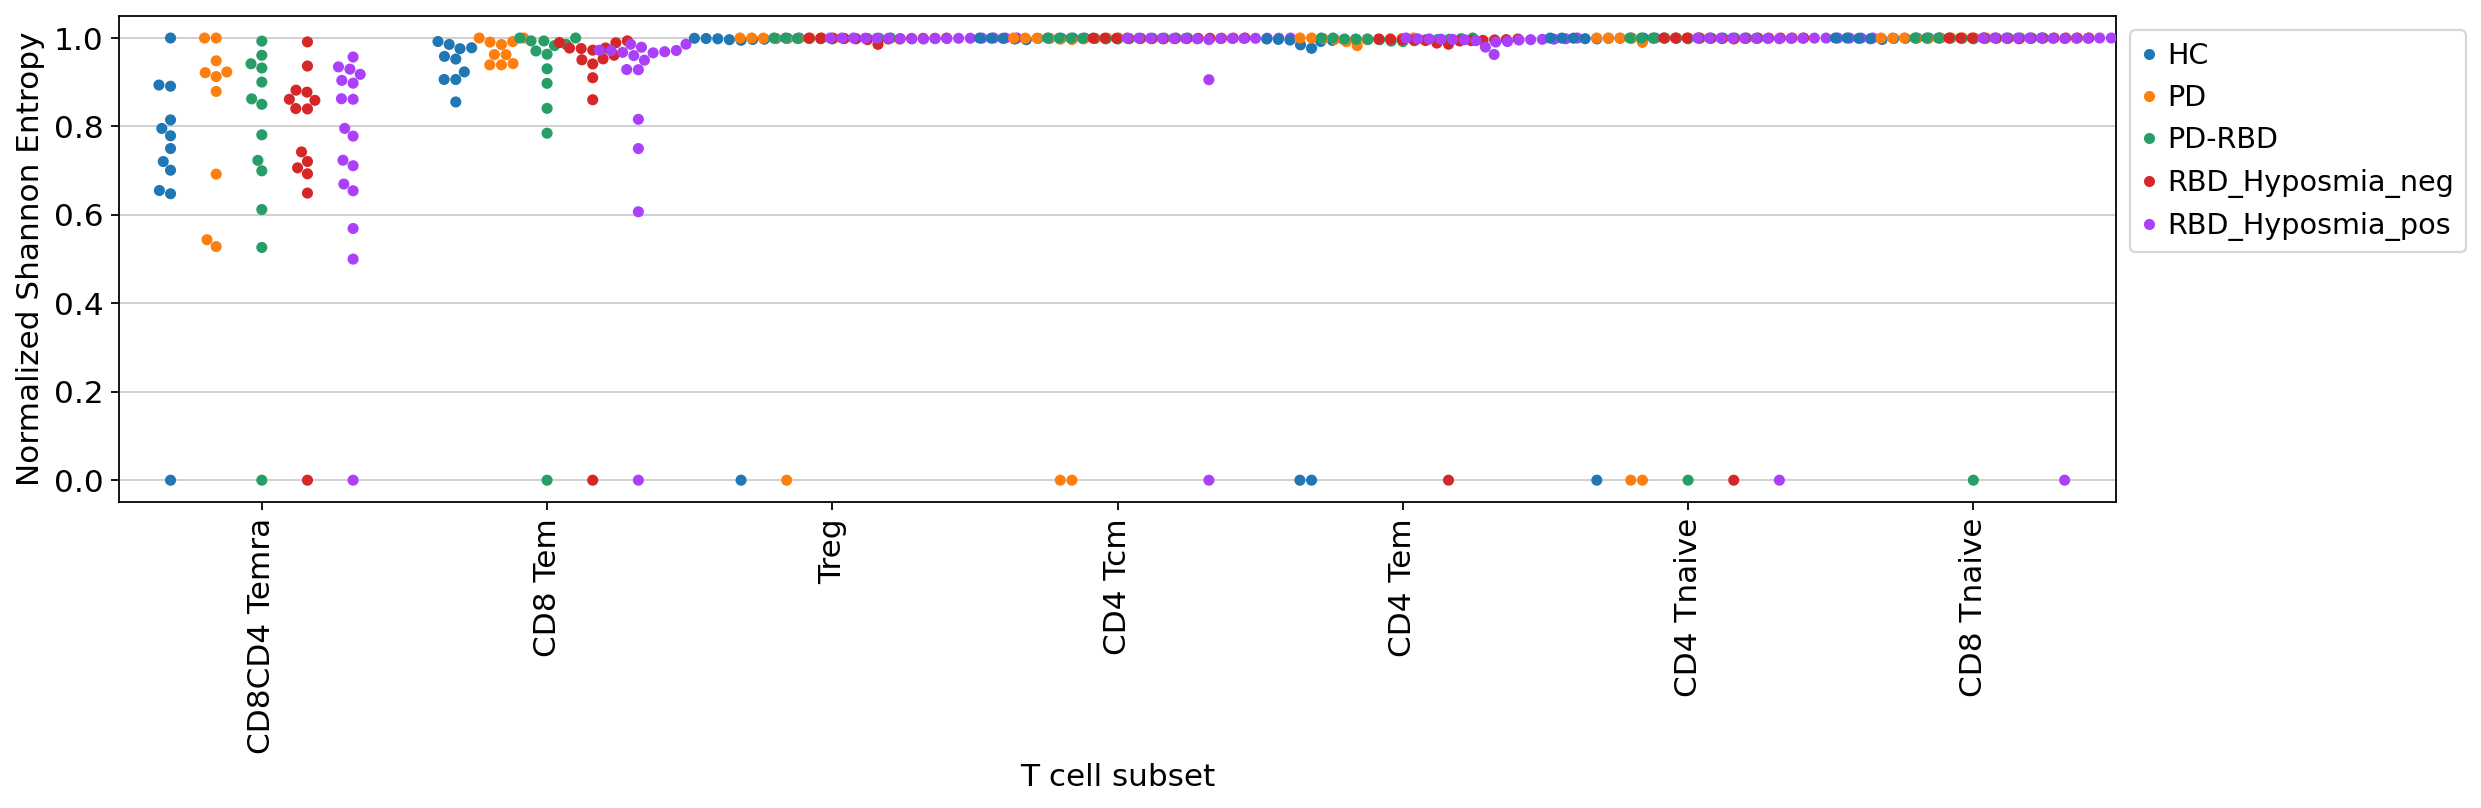

In [31]:
plt.figure(figsize=(16, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='T cell subset', 
    y='Normalized Shannon Entropy', 
    hue='gex:Diagnosis_RBDstrat',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 36.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 32.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


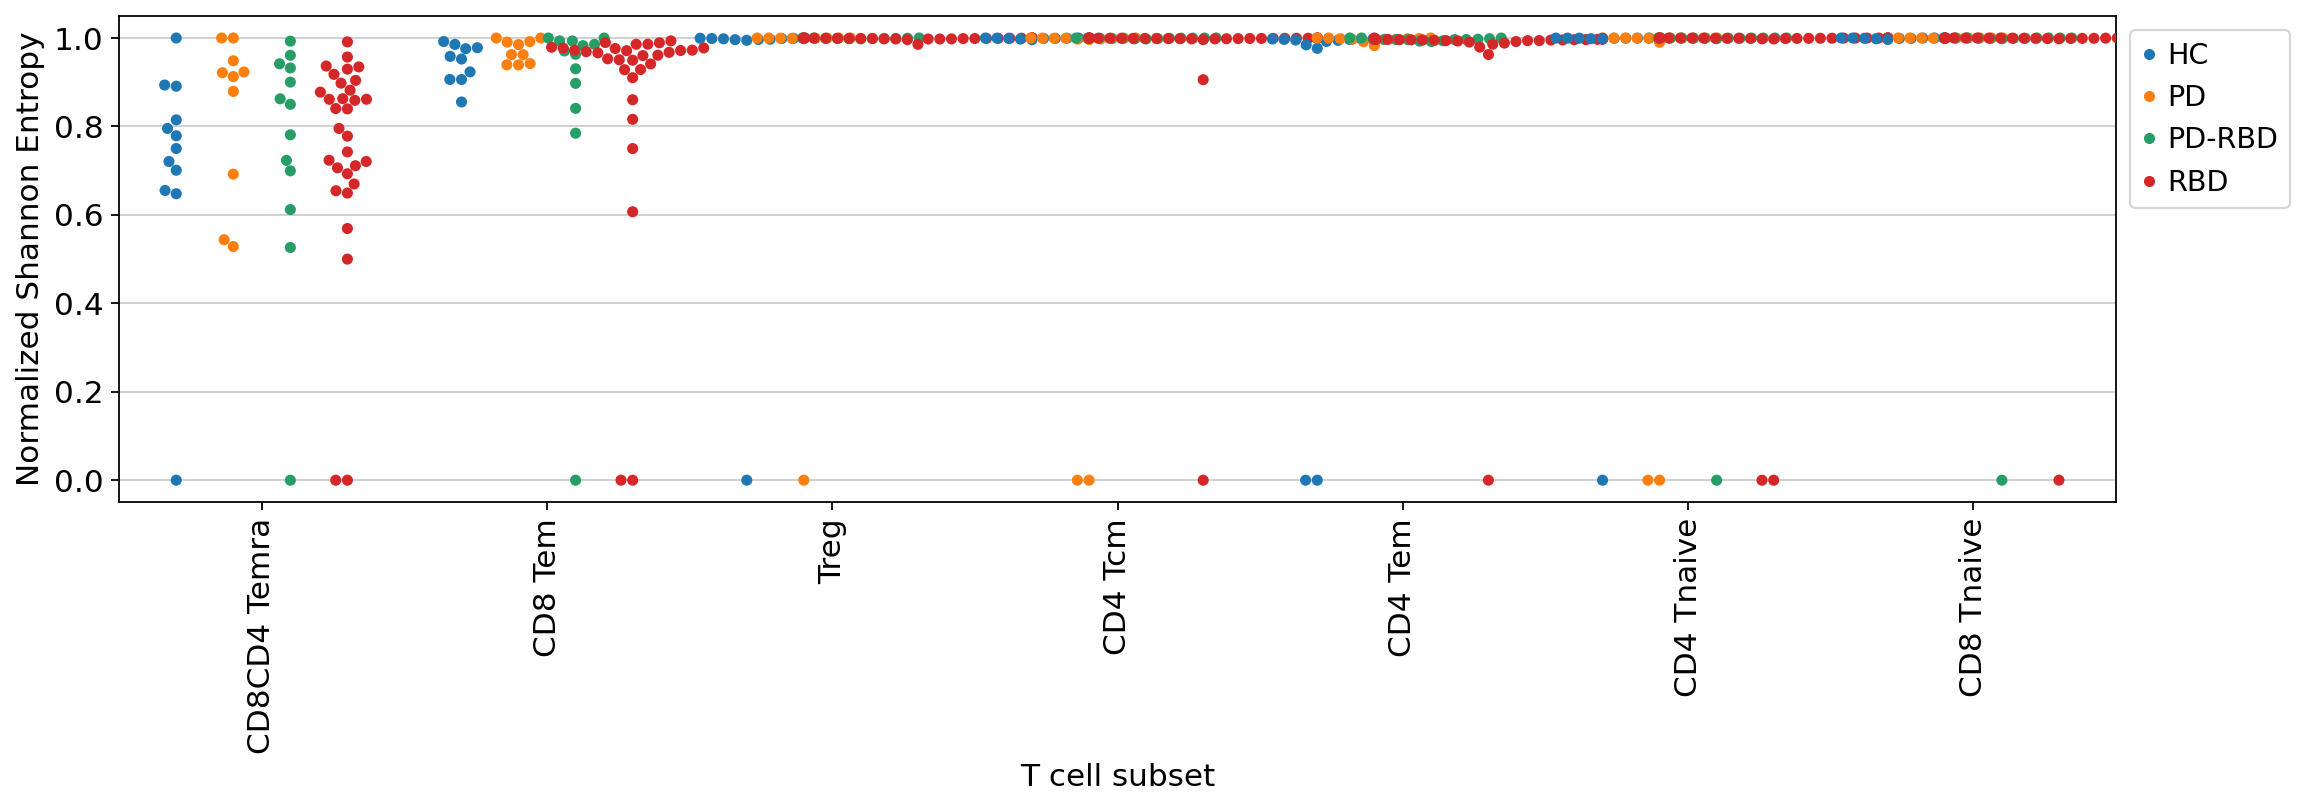

In [32]:
plt.figure(figsize=(16, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='T cell subset', 
    y='Normalized Shannon Entropy', 
    hue='gex:EnrollmentCategory',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [33]:
df_diversity_tidy

index T cell subset  Normalized Shannon Entropy gex:SampleID  \
0    YPD001BLD  CD8CD4 Temra                    0.750037    YPD001BLD   
1    YPD001BLD       CD8 Tem                    0.855331    YPD001BLD   
2    YPD001BLD          Treg                    0.994838    YPD001BLD   
3    YPD001BLD       CD4 Tcm                    0.999128    YPD001BLD   
4    YPD001BLD       CD4 Tem                    0.996828    YPD001BLD   
..         ...           ...                         ...          ...   
450  YPD076BLD       CD4 Tem                    1.000000    YPD076BLD   
451  YPD076BLD    CD4 Tnaive                    1.000000    YPD076BLD   
452  YPD076BLD    CD8 Tnaive                    1.000000    YPD076BLD   
453  YPD095BLD       CD4 Tcm                    0.000000    YPD095BLD   
454  YPD095BLD    CD4 Tnaive                    0.000000    YPD095BLD   

    gex:EnrollmentCategory gex:Diagnosis_RBDstrat  
0                       HC                     HC  
1                       HC                     HC  
2                       HC                     HC  
3                       HC                     HC  
4                       HC                     HC  
..                     ...                    ...  
450                 PD-RBD                 PD-RBD  
451                 PD-RBD                 PD-RBD  
452                 PD-RBD                 PD-RBD  
453                     PD                     PD  
454                     PD                     PD  

[455 rows x 6 columns]

In [34]:
# mann whitney u test for each subset (EnrollmentCategory)
from scipy.stats import mannwhitneyu

list_p = []
for subset in list_tcell:
    for category in ['RBD', 'PD', 'PD-RBD']:
        s1 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == category)&(df_diversity_tidy['T cell subset'] == subset), 'Normalized Shannon Entropy']
        s2 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == 'HC')&(df_diversity_tidy['T cell subset'] == subset), 'Normalized Shannon Entropy']
        _, p = mannwhitneyu(s1, s2)
        list_p.append({'subset': subset, 'category': category, 'p': p, 'mean_cat': s1.mean(), 'mean_hc': s2.mean()})
df_p = pd.DataFrame(list_p)
df_p['fdr'] = multi.fdrcorrection(df_p['p'])[1]

In [ ]:
df_p

subset category         p  mean_cat   mean_hc       fdr
0   CD8CD4 Temra      RBD  0.524519  0.750570  0.720716  0.676248
1   CD8CD4 Temra       PD  0.175973  0.834954  0.720716  0.461929
2   CD8CD4 Temra   PD-RBD  0.513860  0.752553  0.720716  0.676248
3        CD8 Tem      RBD  0.939498  0.876211  0.943349  0.939498
4        CD8 Tem       PD  0.140316  0.971325  0.943349  0.420948
5        CD8 Tem   PD-RBD  0.598091  0.872515  0.943349  0.676248
6           Treg      RBD  0.025265  0.998691  0.907255  0.259621
7           Treg       PD  0.037089  0.899667  0.907255  0.259621
8           Treg   PD-RBD  0.081751  0.999163  0.907255  0.287008
9        CD4 Tcm      RBD  0.456983  0.963904  0.999013  0.676248
10       CD4 Tcm       PD  0.574941  0.832448  0.999013  0.676248
11       CD4 Tcm   PD-RBD  0.475613  0.999294  0.999013  0.676248
12       CD4 Tem      RBD  0.297114  0.961849  0.827491  0.567217
13       CD4 Tem       PD  0.024606  0.996415  0.827491  0.259621
14       CD4 Tem   PD-RBD  0.067627  0.996785  0.827491  0.287008
15    CD4 Tnaive      RBD  0.252404  0.935110  0.908580  0.530048
16    CD4 Tnaive       PD  0.644046  0.832366  0.908580  0.676248
17    CD4 Tnaive   PD-RBD  0.234850  0.922787  0.908580  0.530048
18    CD8 Tnaive      RBD  0.446086  0.965272  0.999237  0.676248
19    CD8 Tnaive       PD  0.082002  0.999843  0.999237  0.287008
20    CD8 Tnaive   PD-RBD  0.637054  0.922725  0.999237  0.676248

subset category         p   mean_cat    mean_hc       fdr
0   CD8CD4 Temra      RBD  0.440217  18.308862  20.056705  0.639587
1   CD8CD4 Temra       PD  0.198262  22.578984  20.056705  0.520438
2   CD8CD4 Temra   PD-RBD  0.549472  24.133238  20.056705  0.678760
3        CD8 Tem      RBD  0.484981  37.180826  29.946764  0.639587
4        CD8 Tem       PD  0.088853  41.112892  29.946764  0.496789
5        CD8 Tem   PD-RBD  0.162794  40.401656  29.946764  0.496789
6           Treg      RBD  0.368749  49.465328  53.535049  0.639587
7           Treg       PD  0.033996  55.005869  53.535049  0.496789
8           Treg   PD-RBD  0.357933  49.739078  53.535049  0.639587
9        CD4 Tcm      RBD  0.915365  50.562304  49.288315  0.920118
10       CD4 Tcm       PD  0.260825  58.264856  49.288315  0.608591
11       CD4 Tcm   PD-RBD  0.475504  52.100055  49.288315  0.639587
12       CD4 Tem      RBD  0.881576  48.653332  54.911129  0.920118
13       CD4 Tem       PD  0.165596  48.090386  54.911129  0.496789
14       CD4 Tem   PD-RBD  0.487304  49.063096  54.911129  0.639587
15    CD4 Tnaive      RBD  0.920118  52.976086  54.190744  0.920118
16    CD4 Tnaive       PD  0.138278  59.398082  54.190744  0.496789
17    CD4 Tnaive   PD-RBD  0.705194  54.180464  54.190744  0.822726
18    CD8 Tnaive      RBD  0.084729  52.488062  49.843350  0.496789
19    CD8 Tnaive       PD  0.137472  50.346337  49.843350  0.496789
20    CD8 Tnaive   PD-RBD  0.382782  53.941588  49.843350  0.639587

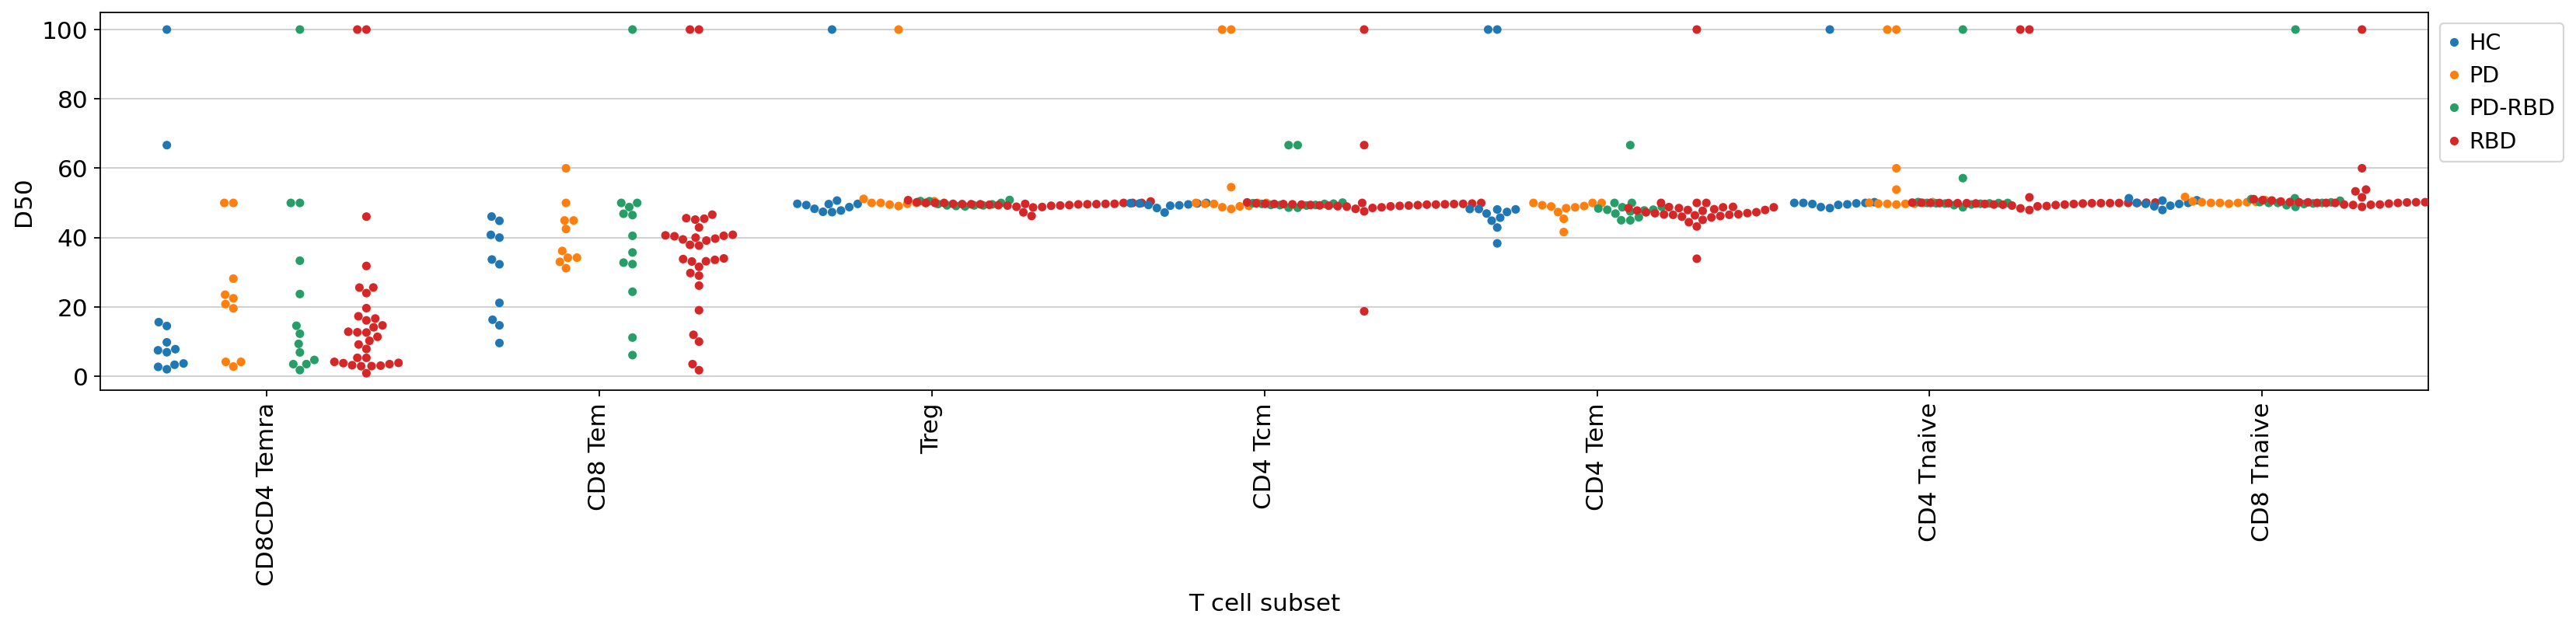

In [36]:
list_df = []
for s in mdata['tcr'].obs['SampleID'].unique():
    # ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
    # airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
    if mdata[mdata.obs['gex:SampleID'] == s]['tcr'].shape[0] > 0:
        d = ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
            airr_mod='tcr', metric="D50", inplace=False)
        d.columns = [s]
        list_df.append(d)
df_diversity = pd.concat(list_df, axis=1).loc[list_tcell].T

df_diversity_tidy = df_diversity.reset_index().melt(
    id_vars='index', value_name='D50', var_name='T cell subset').dropna()

df_diversity_tidy = pd.merge(df_diversity_tidy, 
    mdata.obs[['gex:SampleID', 'gex:EnrollmentCategory', 'gex:Diagnosis_RBDstrat']].dropna().drop_duplicates(),
    left_on='index', right_on='gex:SampleID')

# mann whitney u test for each subset (EnrollmentCategory)
from scipy.stats import mannwhitneyu

list_p = []
for subset in list_tcell:
    for category in ['RBD', 'PD', 'PD-RBD']:
        s1 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == category)&(df_diversity_tidy['T cell subset'] == subset), 'D50']
        s2 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == 'HC')&(df_diversity_tidy['T cell subset'] == subset), 'D50']
        _, p = mannwhitneyu(s1, s2)
        list_p.append({'subset': subset, 'category': category, 'p': p, 'mean_cat': s1.mean(), 'mean_hc': s2.mean()})
df_p = pd.DataFrame(list_p)
df_p['fdr'] = multi.fdrcorrection(df_p['p'])[1]
plt.figure(figsize=(24, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='T cell subset', 
    y='D50', 
    hue='gex:EnrollmentCategory',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

df_p

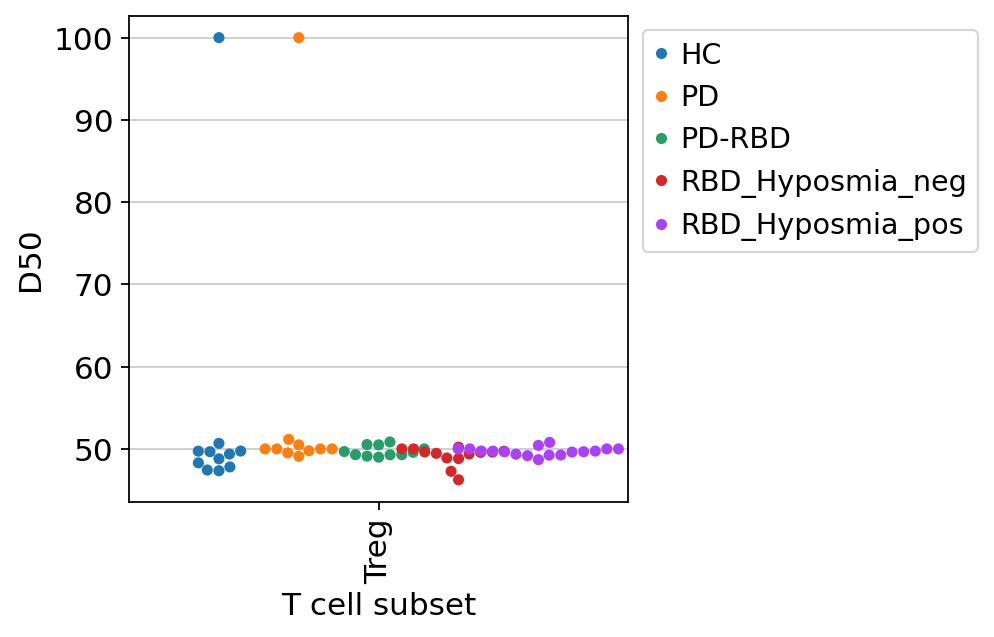

In [37]:
sns.swarmplot(data=df_diversity_tidy[df_diversity_tidy['T cell subset']=='Treg'], 
    x='T cell subset', 
    y='D50', 
    hue='gex:Diagnosis_RBDstrat',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

## BCR

Computing sequence x sequence distance matrix for VJ sequences.


/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/scirpy/ir_dist/metrics.py:733: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  data_rows[row_index][0] = data_row_matrix[thread_id, 0:row_end_index].copy()


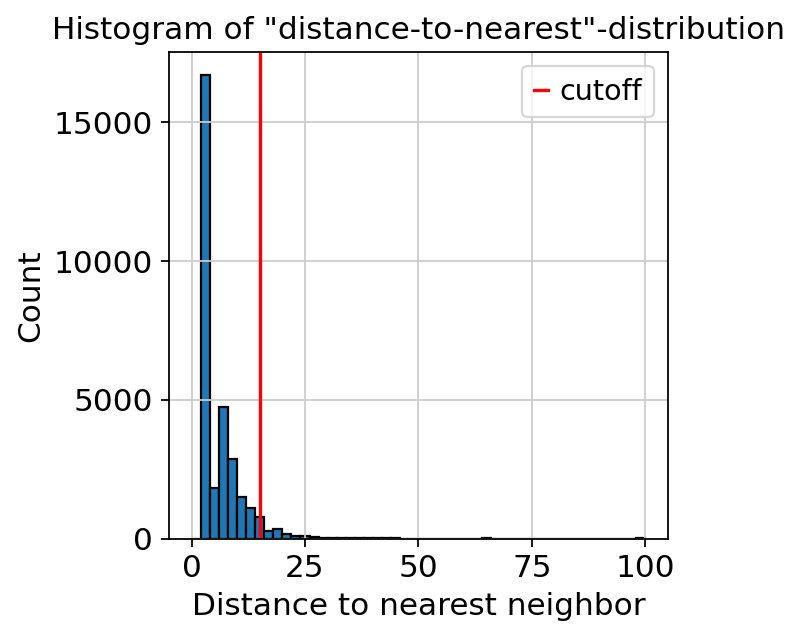

Computing sequence x sequence distance matrix for VDJ sequences.


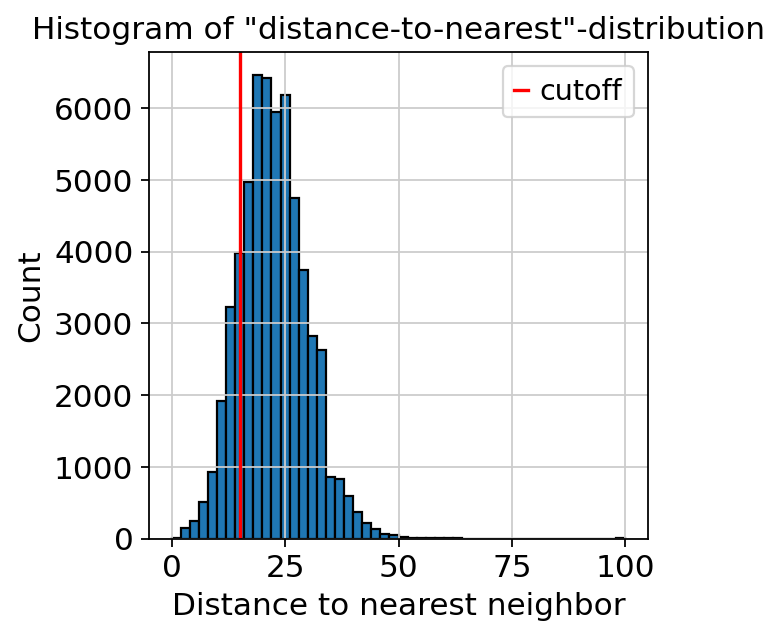

Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:06)
Computing clonotype x clonotype distances.
--> Done computing clonotype x clonotype distances.  (0:00:37)
Stored result in `mdata.obs["bcr:clone_id"]`.
Stored result in `mdata.obs["bcr:clone_id_size"]`.


In [38]:
ir.pp.ir_dist(mdata, airr_mod='bcr', metric="normalized_hamming", cutoff=15, sequence="nt", histogram=True)
ir.tl.define_clonotype_clusters(
    mdata,
    airr_mod='bcr',
    sequence="nt",
    metric="normalized_hamming",
    receptor_arms="all",
    dual_ir="any",
    same_v_gene=True,
    same_j_gene=True,
    # within_group = "gex:patient_id",  # disallow "public" clonotypes
    partitions="fastgreedy",
    key_added="clone_id",
)

In [39]:
ir.tl.clonal_expansion(mdata, airr_mod='bcr', target_col="clone_id", breakpoints=(1, 2))

Stored result in `mdata.obs["bcr:clonal_expansion"]`.


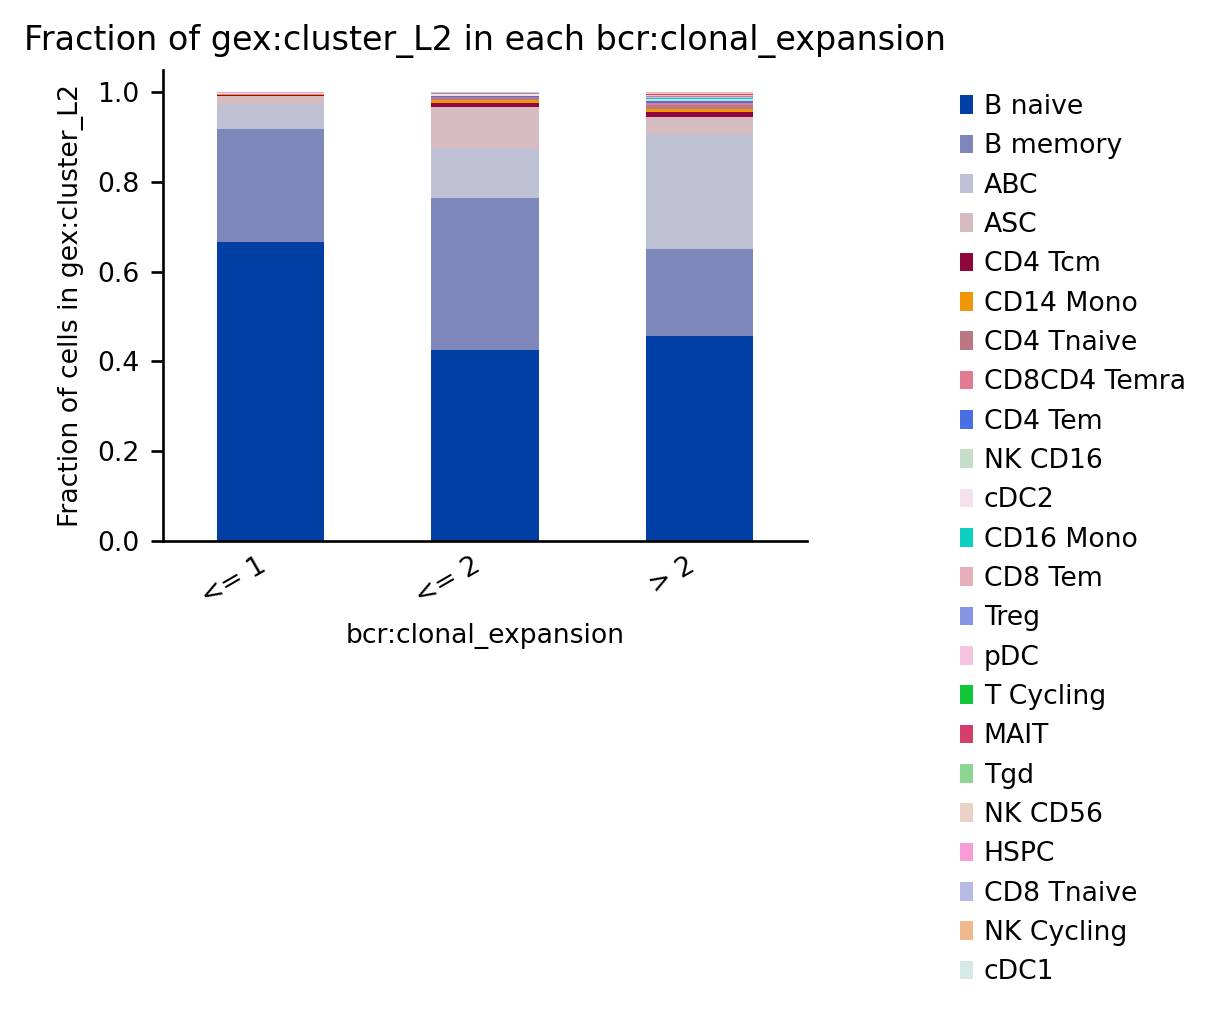

In [40]:
_ = ir.pl.group_abundance(
    mdata,
    target_col="gex:cluster_L2",
    groupby="bcr:clonal_expansion",
    sort=["<= 1", "<= 2", "> 2"],
    normalize=True,
)

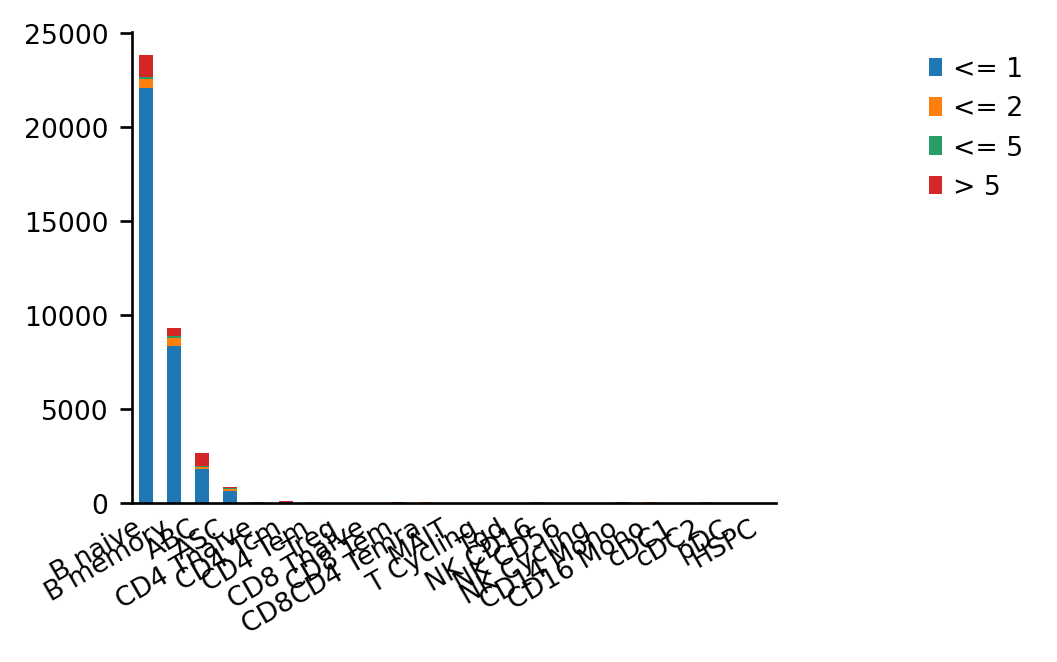

In [41]:
_ = ir.pl.clonal_expansion(mdata, airr_mod='bcr', target_col="clone_id", groupby="gex:cluster_L2", breakpoints=(1, 2, 5), normalize=False)

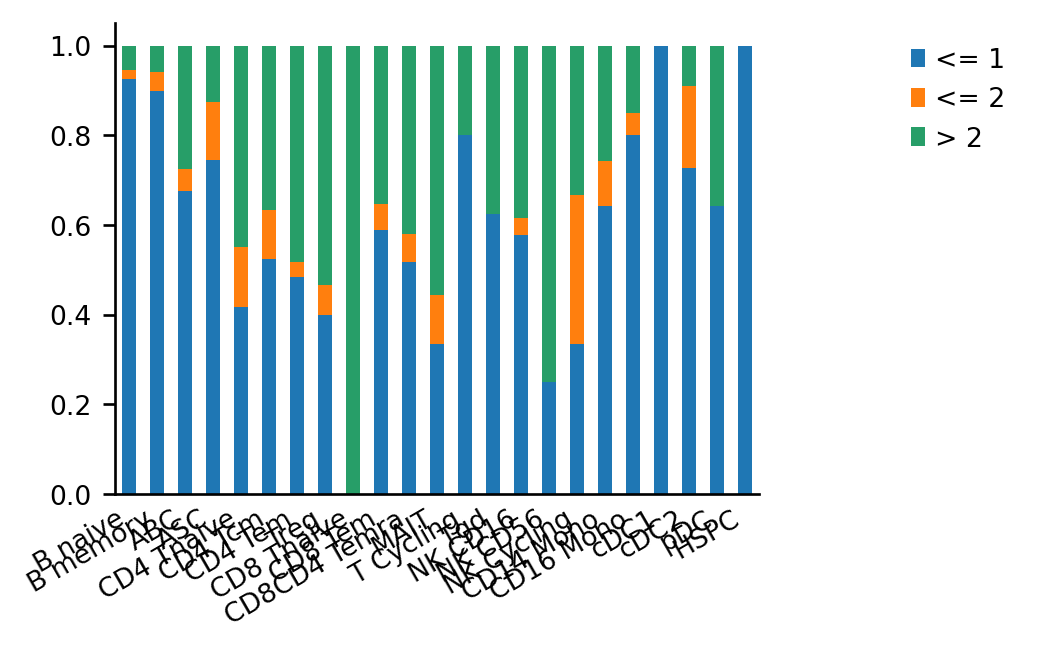

In [42]:
_ = ir.pl.clonal_expansion(
    mdata,
    airr_mod='bcr',
    target_col="clone_id",
    breakpoints=(1, 2),
    groupby="gex:cluster_L2",
    normalize=True,
)

In [43]:
list_bcell = [ 'B memory',
 'B naive',
 'ASC',
 'ABC',
]

In [44]:
list_df = []
for s in mdata['bcr'].obs['SampleID'].unique():
    if mdata[mdata.obs['gex:SampleID'] == s]['bcr'].shape[0] > 0:
        d = ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
            airr_mod='bcr', metric="normalized_shannon_entropy", inplace=False)
        d.columns = [s]
        list_df.append(d)
df_diversity = pd.concat(list_df, axis=1).loc[list_bcell].T

In [45]:
df_diversity_tidy = df_diversity.reset_index().melt(
    id_vars='index', value_name='Normalized Shannon Entropy', var_name='B cell subset').dropna()

df_diversity_tidy = pd.merge(df_diversity_tidy, 
    mdata.obs[['gex:SampleID', 'gex:EnrollmentCategory', 'gex:Diagnosis_RBDstrat']].dropna().drop_duplicates(),
    left_on='index', right_on='gex:SampleID')

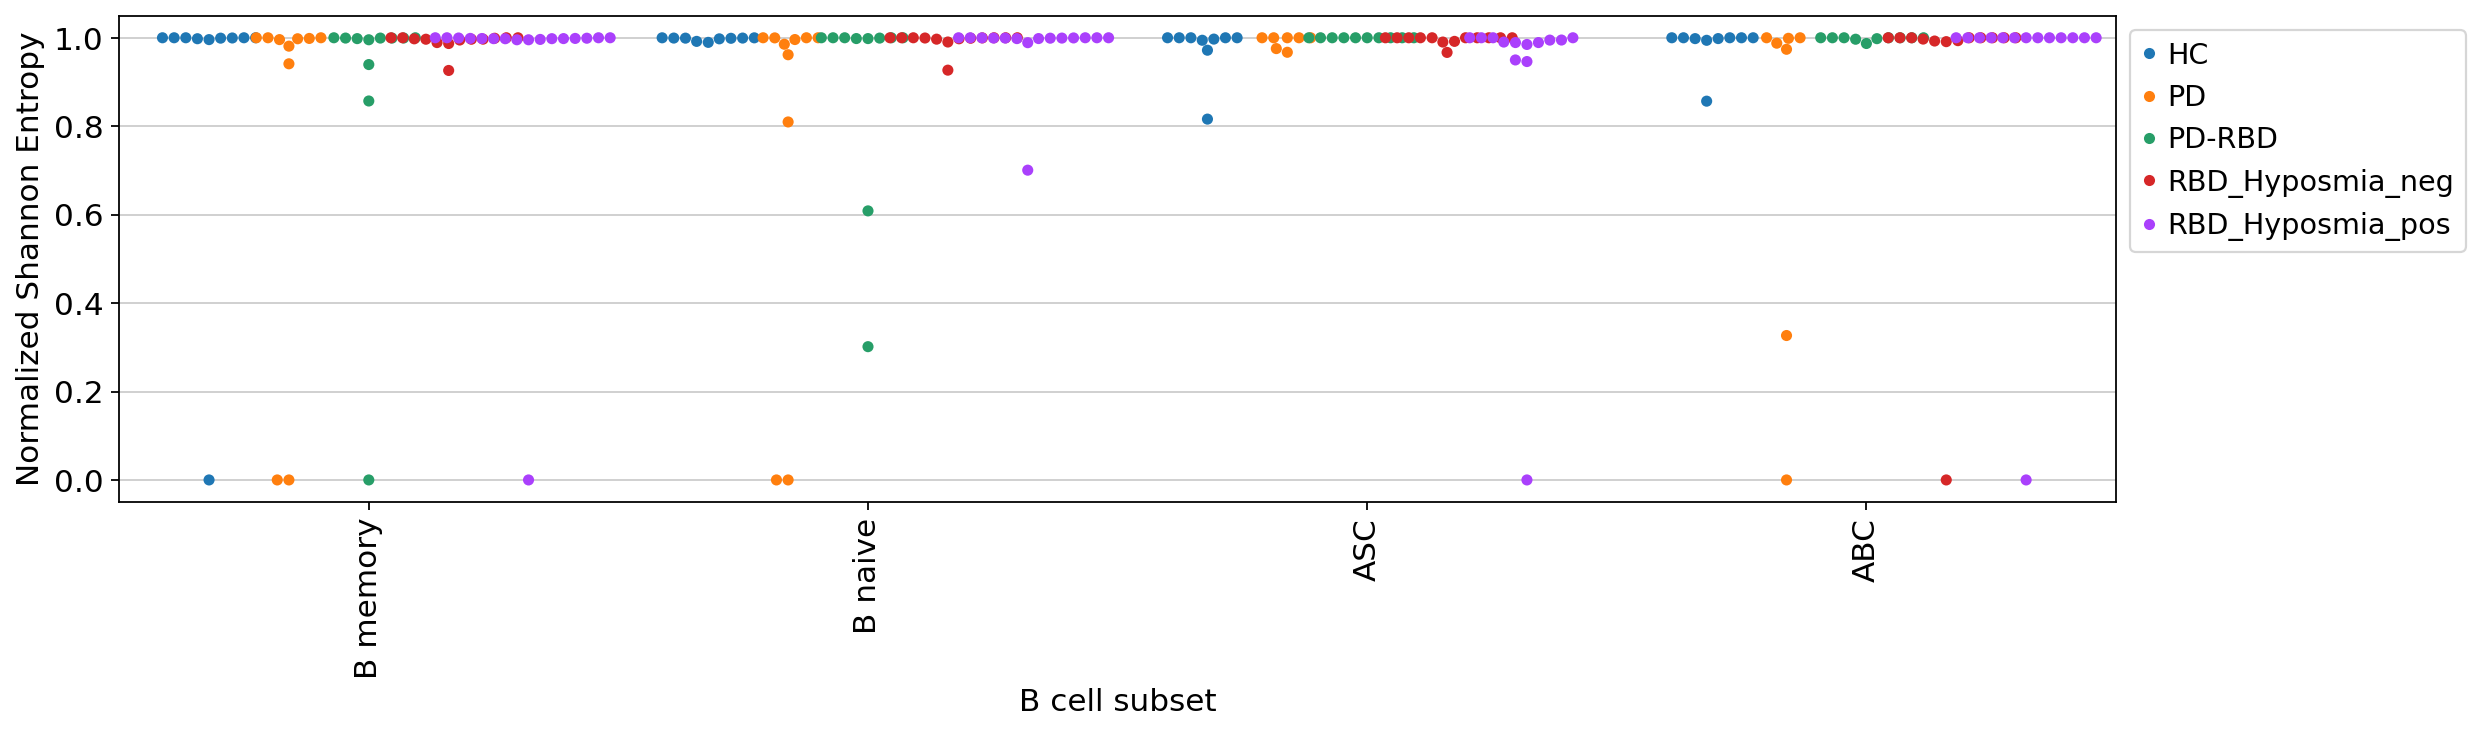

In [46]:
plt.figure(figsize=(16, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='B cell subset', 
    y='Normalized Shannon Entropy', 
    hue='gex:Diagnosis_RBDstrat',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

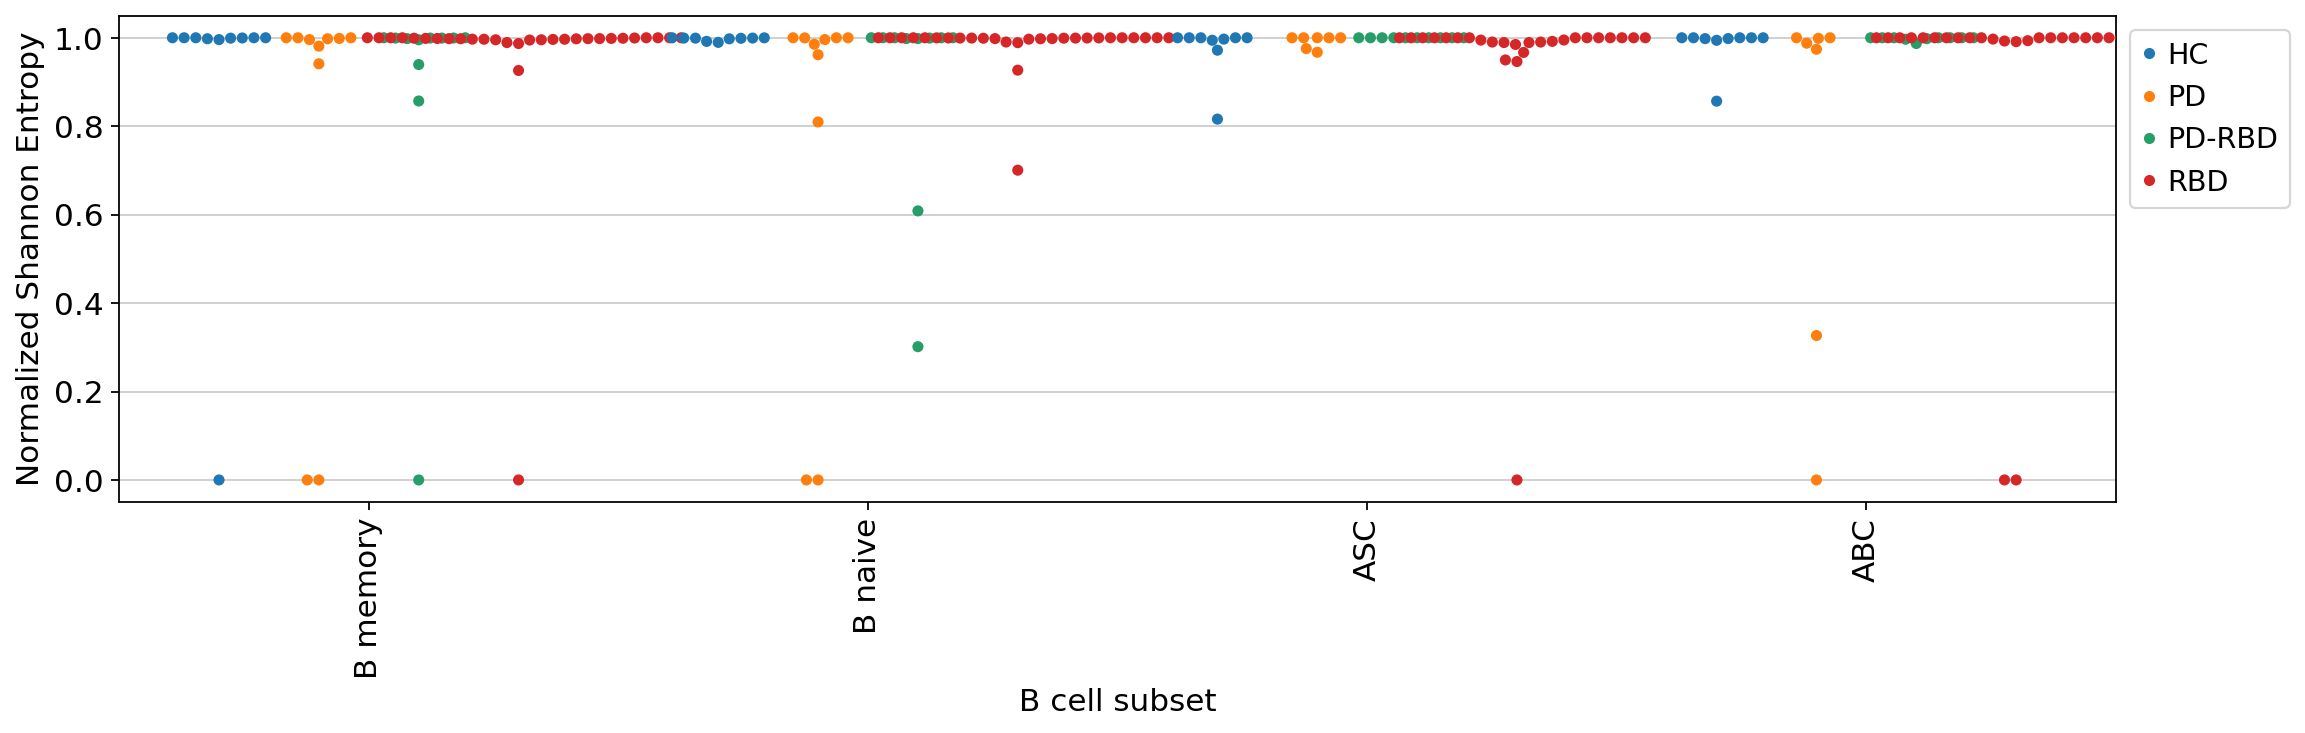

In [47]:
plt.figure(figsize=(16, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='B cell subset', 
    y='Normalized Shannon Entropy', 
    hue='gex:EnrollmentCategory',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [48]:
# mann whitney u test for each subset (EnrollmentCategory)
from scipy.stats import mannwhitneyu

list_p = []
for subset in list_bcell:
    for category in ['RBD', 'PD', 'PD-RBD']:
        s1 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == category)&(df_diversity_tidy['B cell subset'] == subset), 'Normalized Shannon Entropy']
        s2 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == 'HC')&(df_diversity_tidy['B cell subset'] == subset), 'Normalized Shannon Entropy']
        _, p = mannwhitneyu(s1, s2)
        list_p.append({'subset': subset, 'category': category, 'p': p, 'mean_cat': s1.mean(), 'mean_hc': s2.mean()})
df_p = pd.DataFrame(list_p)
df_p['fdr'] = multi.fdrcorrection(df_p['p'])[1]

In [49]:
df_p

subset category         p  mean_cat   mean_hc       fdr
0   B memory      RBD  0.154682  0.961890  0.899232  0.416654
1   B memory       PD  0.119543  0.791422  0.899232  0.416654
2   B memory   PD-RBD  0.306282  0.889757  0.899232  0.522912
3    B naive      RBD  0.208327  0.985423  0.997259  0.416654
4    B naive       PD  0.487286  0.775229  0.997259  0.584743
5    B naive   PD-RBD  0.390851  0.890551  0.997259  0.522912
6        ASC      RBD  0.801086  0.953387  0.975472  0.801086
7        ASC       PD  0.580610  0.991815  0.975472  0.633392
8        ASC   PD-RBD  0.194297  1.000000  0.975472  0.416654
9        ABC      RBD  0.047257  0.924975  0.983009  0.416654
10       ABC       PD  0.392184  0.755300  0.983009  0.522912
11       ABC   PD-RBD  0.105329  0.998169  0.983009  0.416654

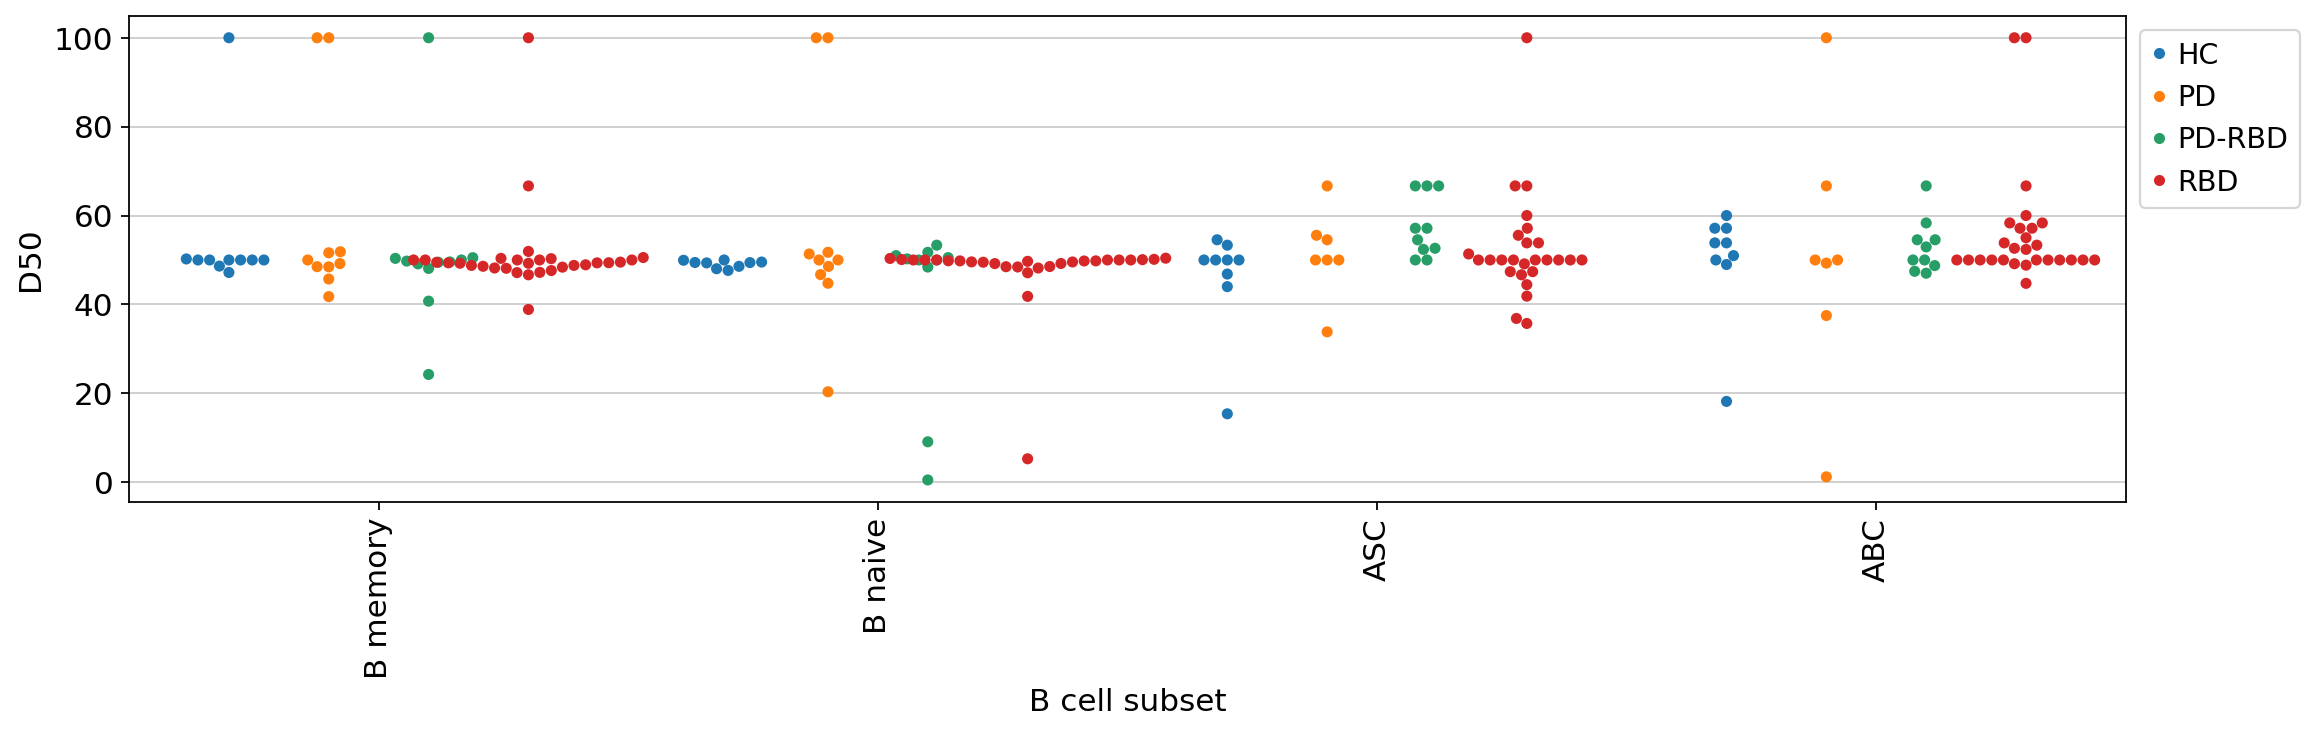

In [50]:
list_df = []
for s in mdata['bcr'].obs['SampleID'].unique():
    # ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
    # airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
    if mdata[mdata.obs['gex:SampleID'] == s]['bcr'].shape[0] > 0:
        d = ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
            airr_mod='bcr', metric="D50", inplace=False)
        d.columns = [s]
        list_df.append(d)
df_diversity = pd.concat(list_df, axis=1).loc[list_bcell].T

df_diversity_tidy = df_diversity.reset_index().melt(
    id_vars='index', value_name='D50', var_name='B cell subset').dropna()

df_diversity_tidy = pd.merge(df_diversity_tidy, 
    mdata.obs[['gex:SampleID', 'gex:EnrollmentCategory', 'gex:Diagnosis_RBDstrat']].dropna().drop_duplicates(),
    left_on='index', right_on='gex:SampleID')

# mann whitney u test for each subset (EnrollmentCategory)
from scipy.stats import mannwhitneyu

list_p = []
for subset in list_bcell:
    for category in ['RBD', 'PD', 'PD-RBD']:
        s1 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == category)&(df_diversity_tidy['B cell subset'] == subset), 'D50']
        s2 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == 'HC')&(df_diversity_tidy['B cell subset'] == subset), 'D50']
        _, p = mannwhitneyu(s1, s2)
        list_p.append({'subset': subset, 'category': category, 'p': p, 'mean_cat': s1.mean(), 'mean_hc': s2.mean()})
df_p = pd.DataFrame(list_p)
df_p['fdr'] = multi.fdrcorrection(df_p['p'])[1]
df_p

plt.figure(figsize=(16, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='B cell subset', 
    y='D50', 
    hue='gex:EnrollmentCategory',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [51]:
mdata.write(results_file_mu)

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


## CD4T

In [52]:
mdata = mu.read(results_file_mu)

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/gibbs/project/hafler/yy693/c

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


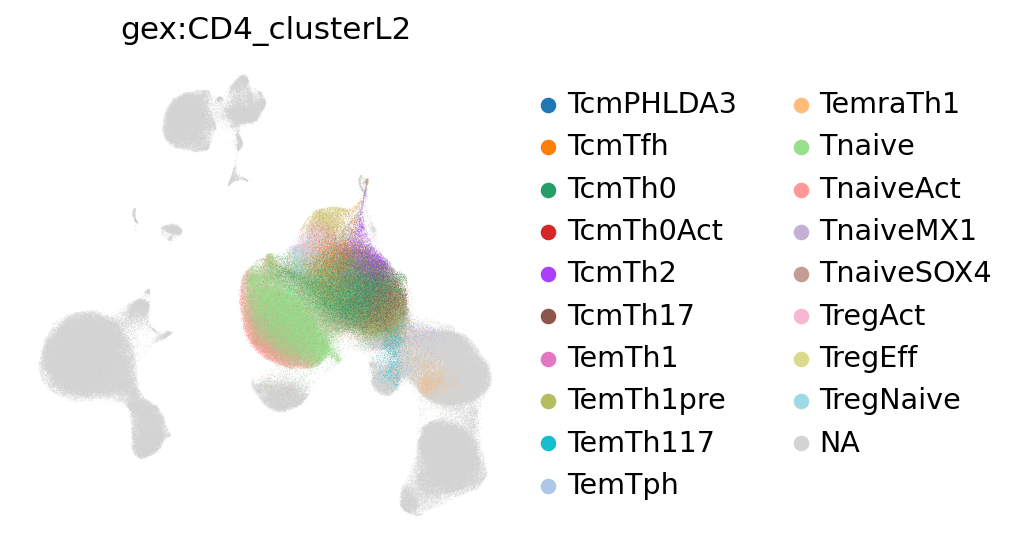

In [53]:
df_cd4 = pd.read_csv('../output/241029_BLD_CD4T_tidy_queryL2_output.full.csv', index_col=0)
df_cd4.index = df_cd4.index + '-' + df_cd4['sample'] + 'BLD'
df_cd4.columns = ['CD4_clusterL1', 'CD4_clusterL1_prob', 'CD4_clusterL2', 'CD4_clusterL2_prob', 'age',
       'sex', 'disease', 'sample']
df_cd4 = df_cd4[['CD4_clusterL1', 'CD4_clusterL1_prob', 'CD4_clusterL2', 'CD4_clusterL2_prob']]

mdata['gex'].obs = pd.merge(mdata['gex'].obs, df_cd4, left_index=True, right_index=True, how='left')
mdata.update()

mu.pl.embedding(mdata, basis="gex:umap_filtered", color=["gex:CD4_clusterL2"])

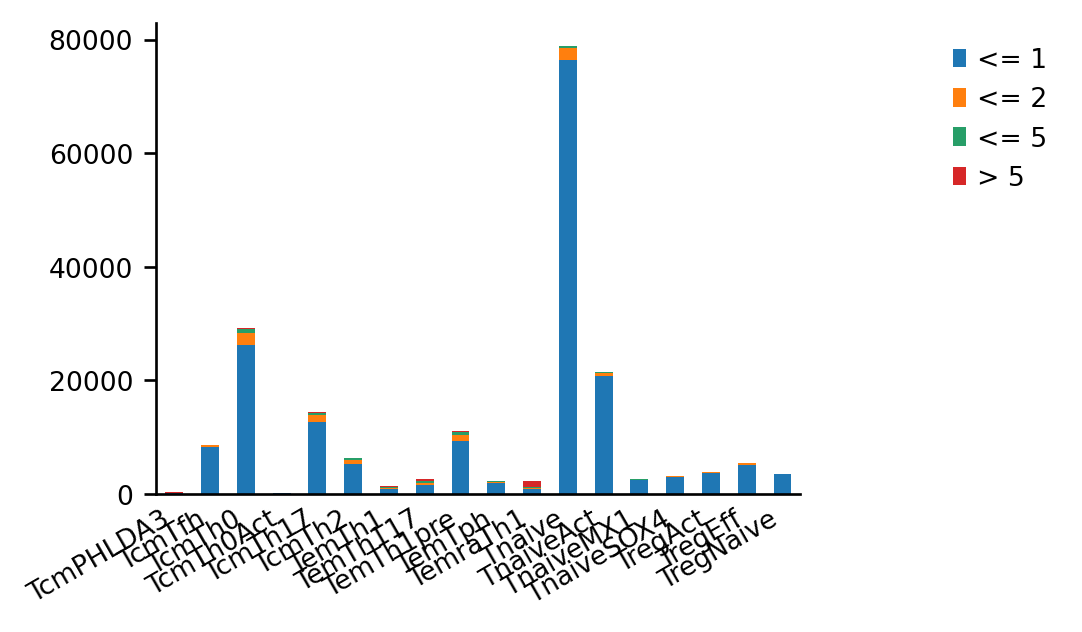

In [54]:
_ = ir.pl.clonal_expansion(mdata, airr_mod='tcr', target_col="clone_id", groupby="gex:CD4_clusterL2", breakpoints=(1, 2, 5), normalize=False)

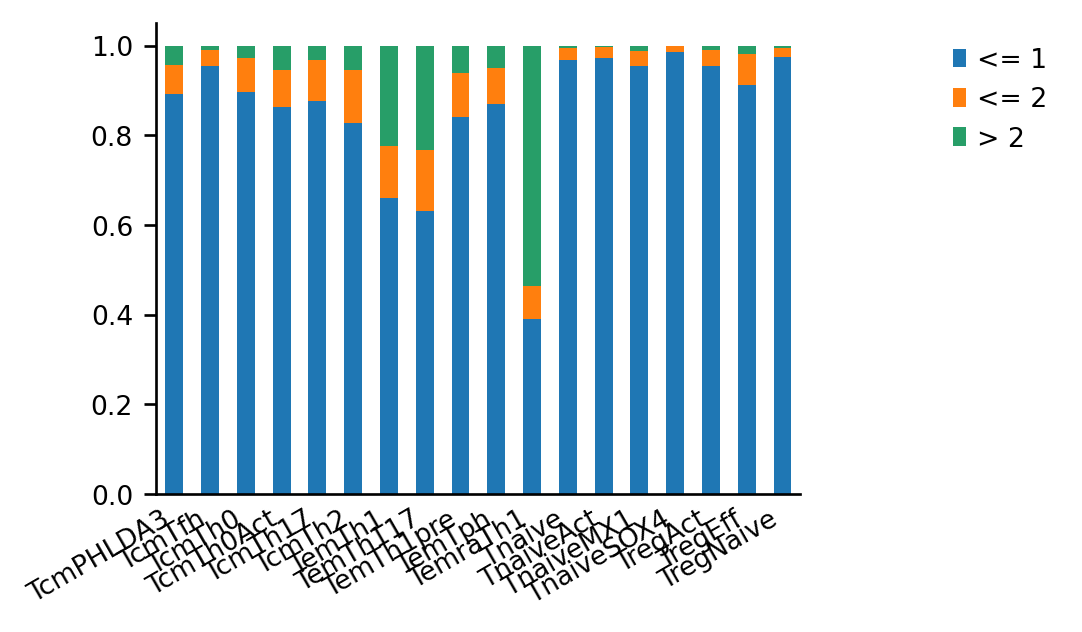

In [55]:
_ = ir.pl.clonal_expansion(
    mdata,
    airr_mod='tcr',
    target_col="clone_id",
    breakpoints=(1, 2),
    groupby="gex:CD4_clusterL2",
    normalize=True,
)

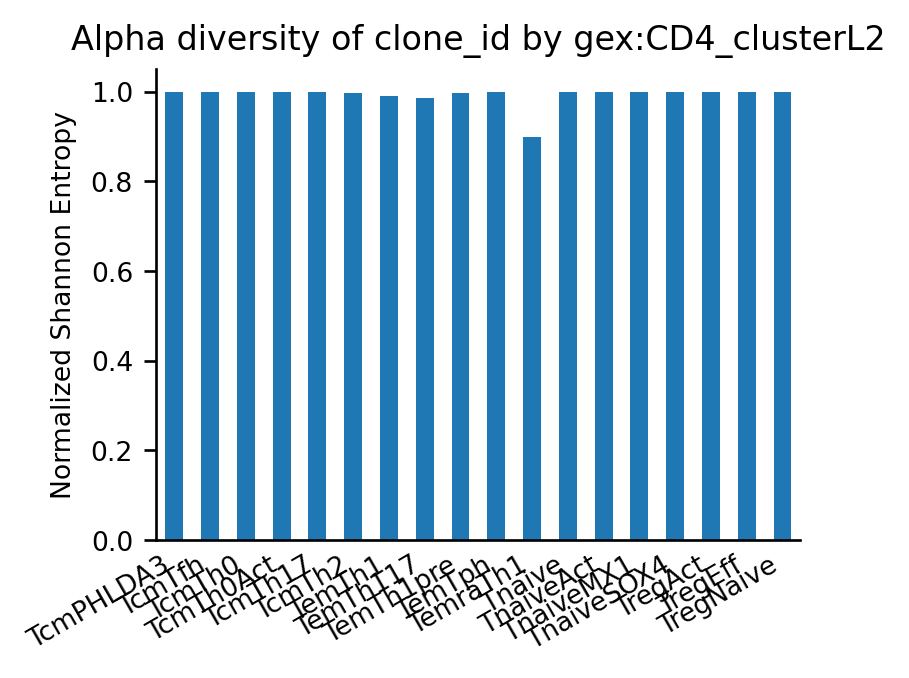

In [56]:
_ = ir.pl.alpha_diversity(mdata, airr_mod='tcr', metric="normalized_shannon_entropy", groupby="gex:CD4_clusterL2")

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size o

subset category         p  mean_cat   mean_hc       fdr
0    TcmPHLDA3      RBD  0.384272  0.875000  1.000000  0.827494
1    TcmPHLDA3       PD  0.594374  1.000000  1.000000  0.867465
2    TcmPHLDA3   PD-RBD  0.855552  0.777778  1.000000  0.978820
3       TcmTfh      RBD  0.556860  0.932254  0.999580  0.867465
4       TcmTfh       PD  0.305089  0.888577  0.999580  0.814172
5       TcmTfh   PD-RBD  0.444395  0.916439  0.999580  0.827494
6       TcmTh0      RBD  0.316622  0.934179  0.907530  0.814172
7       TcmTh0       PD  0.112634  0.998984  0.907530  0.467865
8       TcmTh0   PD-RBD  0.154233  0.927584  0.907530  0.520536
9    TcmTh0Act      RBD  0.534630  0.800000  0.775841  0.867465
10   TcmTh0Act       PD  0.397422  0.833333  0.775841  0.827494
11   TcmTh0Act   PD-RBD  0.924442  0.888889  0.775841  0.978820
12     TcmTh17      RBD  0.881391  0.997760  0.997944  0.978820
13     TcmTh17       PD  1.000000  0.816291  0.997944  1.000000
14     TcmTh17   PD-RBD  0.716859  0.914451  0.997944  0.972249
15      TcmTh2      RBD  0.435969  0.961043  0.996443  0.827494
16      TcmTh2       PD  0.967436  0.885753  0.996443  0.985689
17      TcmTh2   PD-RBD  0.915878  0.996372  0.996443  0.978820
18      TemTh1      RBD  0.492674  0.991685  0.989163  0.858206
19      TemTh1       PD  0.417831  0.991273  0.989163  0.827494
20      TemTh1   PD-RBD  0.768873  0.906536  0.989163  0.972249
21    TemTh117      RBD  0.572285  0.940342  0.989183  0.867465
22    TemTh117       PD  0.079048  0.866762  0.989183  0.411636
23    TemTh117   PD-RBD  0.915578  0.981832  0.989183  0.978820
24   TemTh1pre      RBD  0.129664  0.997511  0.905306  0.500133
25   TemTh1pre       PD  0.947571  0.815735  0.905306  0.984016
26   TemTh1pre   PD-RBD  0.014806  0.998629  0.905306  0.325242
27      TemTph      RBD  0.774198  0.997386  0.998874  0.972249
28      TemTph       PD  0.900821  0.887760  0.998874  0.978820
29      TemTph   PD-RBD  0.352672  0.998845  0.998874  0.827494
30    TemraTh1      RBD  0.908651  0.907346  0.941633  0.978820
31    TemraTh1       PD  0.264558  0.998786  0.941633  0.793675
32    TemraTh1   PD-RBD  0.774012  0.982558  0.941633  0.972249
33      Tnaive      RBD  0.069226  0.967355  0.908486  0.411636
34      Tnaive       PD  0.074075  0.916493  0.908486  0.411636
35      Tnaive   PD-RBD  0.042730  0.928343  0.908486  0.329631
36   TnaiveAct      RBD  0.246862  0.999740  0.908821  0.784151
37   TnaiveAct       PD  0.038670  0.999948  0.908821  0.329631
38   TnaiveAct   PD-RBD  0.083852  0.999838  0.908821  0.411636
39   TnaiveMX1      RBD  0.592384  0.999672  0.999582  0.867465
40   TnaiveMX1       PD  0.764349  0.888752  0.999582  0.972249
41   TnaiveMX1   PD-RBD  0.485860  1.000000  0.999582  0.858206
42  TnaiveSOX4      RBD  0.338979  0.931034  1.000000  0.827494
43  TnaiveSOX4       PD  0.891204  0.888889  1.000000  0.978820
44  TnaiveSOX4   PD-RBD  0.303486  0.916667  1.000000  0.814172
45     TregAct      RBD  0.545540  0.930407  0.999051  0.867465
46     TregAct       PD  0.102398  0.888814  0.999051  0.460790
47     TregAct   PD-RBD  0.409246  0.999540  0.999051  0.827494
48     TregEff      RBD  0.024092  0.997991  0.996243  0.325242
49     TregEff       PD  0.007623  0.999038  0.996243  0.325242
50     TregEff   PD-RBD  0.021888  0.998222  0.996243  0.325242
51   TregNaive      RBD  0.610662  0.930552  0.999510  0.867782
52   TregNaive       PD  0.040786  1.000000  0.999510  0.329631
53   TregNaive   PD-RBD  0.149305  0.999936  0.999510  0.520536

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size 

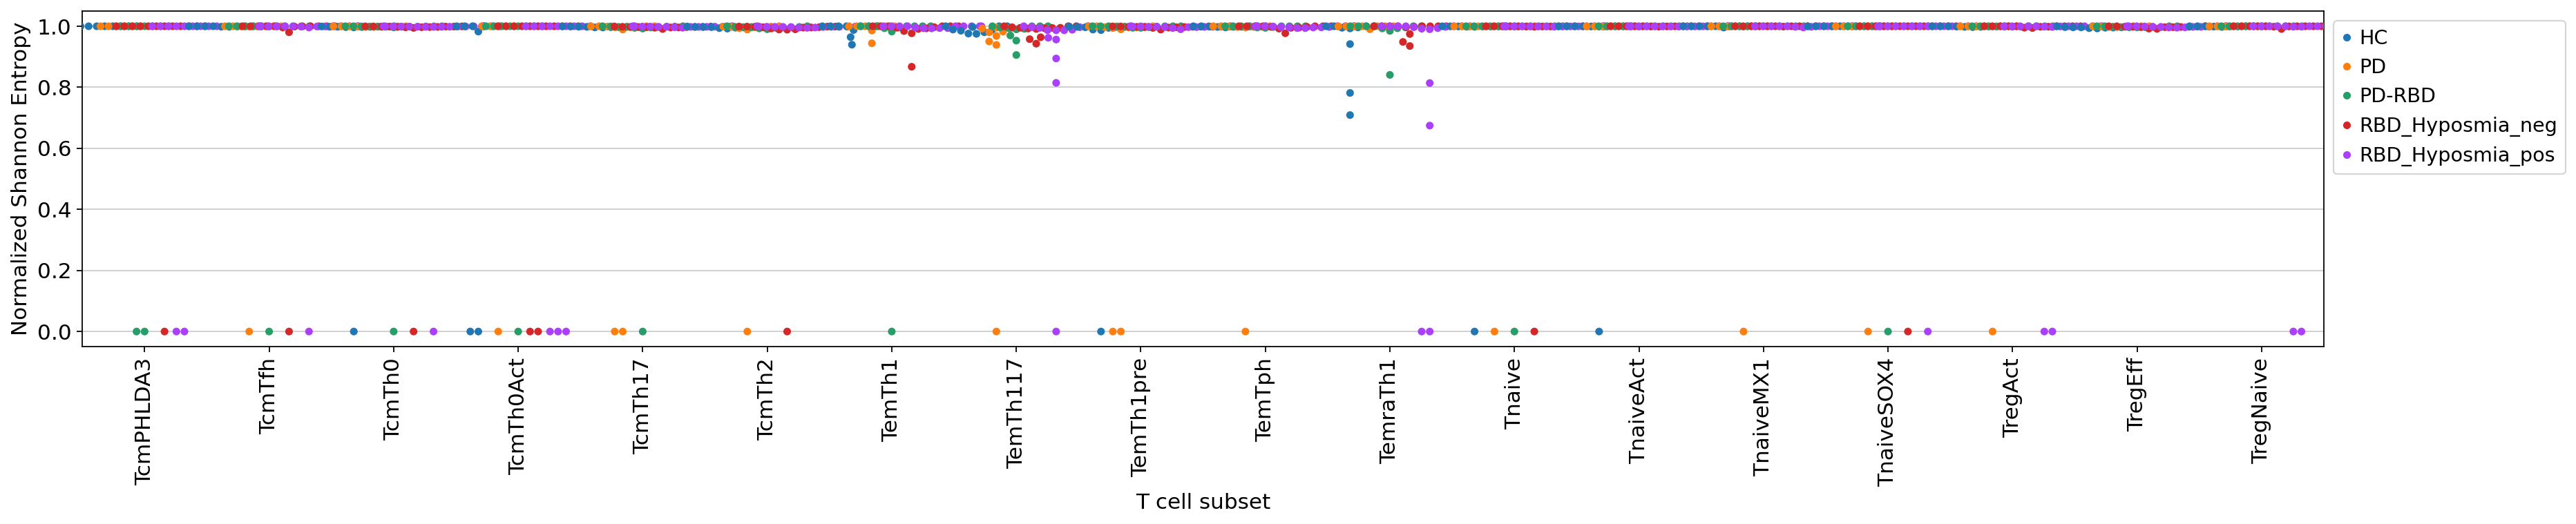

In [57]:
list_df = []
for s in mdata['tcr'].obs['SampleID'].unique():
    # ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
    # airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
    if mdata[(mdata.obs['gex:SampleID'] == s)&(mdata.obs['tcr:receptor_type']=='TCR')]['gex'].obs['CD4_clusterL2'].dropna().shape[0] > 0:
        d = ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:CD4_clusterL2", 
            airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
        d.columns = [s]
        list_df.append(d)
df_diversity = pd.concat(list_df, axis=1).T# .loc[list_tcell].T

df_diversity_tidy = df_diversity.reset_index().melt(
    id_vars='index', value_name='Normalized Shannon Entropy', var_name='T cell subset').dropna()

df_diversity_tidy = pd.merge(df_diversity_tidy, 
    mdata.obs[['gex:SampleID', 'gex:EnrollmentCategory', 'gex:Diagnosis_RBDstrat']].dropna().drop_duplicates(),
    left_on='index', right_on='gex:SampleID')
    
plt.figure(figsize=(26, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='T cell subset', 
    y='Normalized Shannon Entropy', 
    hue='gex:Diagnosis_RBDstrat',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# mann whitney u test for each subset (EnrollmentCategory)
from scipy.stats import mannwhitneyu

list_p = []
for subset in df_diversity.columns:
    for category in ['RBD', 'PD', 'PD-RBD']:
        s1 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == category)&(df_diversity_tidy['T cell subset'] == subset), 'Normalized Shannon Entropy']
        s2 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == 'HC')&(df_diversity_tidy['T cell subset'] == subset), 'Normalized Shannon Entropy']
        _, p = mannwhitneyu(s1, s2)
        list_p.append({'subset': subset, 'category': category, 'p': p, 'mean_cat': s1.mean(), 'mean_hc': s2.mean()})
df_p = pd.DataFrame(list_p)
df_p['fdr'] = multi.fdrcorrection(df_p['p'])[1]
df_p

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


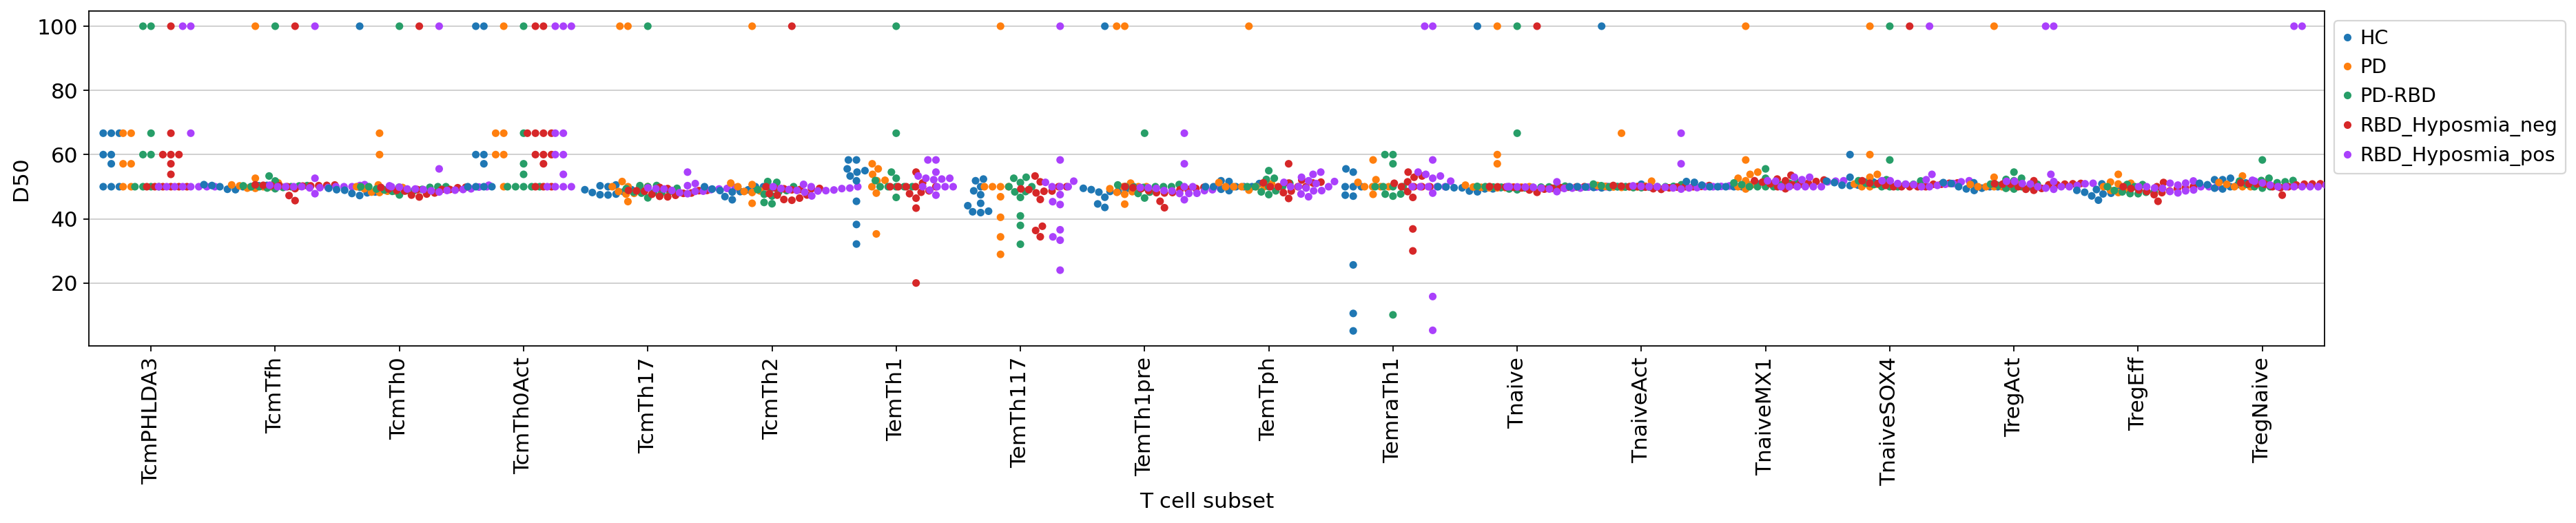

In [58]:
list_df = []
for s in mdata['tcr'].obs['SampleID'].unique():
    # ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
    # airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
    if mdata[(mdata.obs['gex:SampleID'] == s)&(mdata.obs['tcr:receptor_type']=='TCR')]['gex'].obs['CD4_clusterL2'].dropna().shape[0] > 0:
        d = ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:CD4_clusterL2", 
            airr_mod='tcr', metric="D50", inplace=False)
        d.columns = [s]
        list_df.append(d)
df_diversity = pd.concat(list_df, axis=1).T# .loc[list_tcell].T

df_diversity_tidy = df_diversity.reset_index().melt(
    id_vars='index', value_name='D50', var_name='T cell subset').dropna()

df_diversity_tidy = pd.merge(df_diversity_tidy, 
    mdata.obs[['gex:SampleID', 'gex:EnrollmentCategory', 'gex:Diagnosis_RBDstrat']].dropna().drop_duplicates(),
    left_on='index', right_on='gex:SampleID')
    
plt.figure(figsize=(26, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='T cell subset', 
    y='D50', 
    hue='gex:Diagnosis_RBDstrat',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [59]:
# mann whitney u test for each subset (EnrollmentCategory)
from scipy.stats import mannwhitneyu

list_p = []
for subset in df_diversity.columns:
    for category in ['RBD', 'PD', 'PD-RBD']:
        s1 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == category)&(df_diversity_tidy['T cell subset'] == subset), 'D50']
        s2 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == 'HC')&(df_diversity_tidy['T cell subset'] == subset), 'D50']
        _, p = mannwhitneyu(s1, s2)
        list_p.append({'subset': subset, 'category': category, 'p': p, 'mean_cat': s1.mean(), 'mean_hc': s2.mean()})
df_p = pd.DataFrame(list_p)
df_p['fdr'] = multi.fdrcorrection(df_p['p'])[1]
df_p

subset category         p   mean_cat    mean_hc       fdr
0    TcmPHLDA3      RBD  0.314986  59.346764  58.571429  0.716639
1    TcmPHLDA3       PD  0.853748  57.936508  58.571429  0.974033
2    TcmPHLDA3   PD-RBD  0.963296  65.185185  58.571429  1.000000
3       TcmTfh      RBD  0.987408  53.225413  50.074073  1.000000
4       TcmTfh       PD  0.483808  55.963941  50.074073  0.842762
5       TcmTfh   PD-RBD  0.894036  54.558106  50.074073  0.974033
6       TcmTh0      RBD  0.345048  52.592977  53.411048  0.716639
7       TcmTh0       PD  0.275063  52.008280  53.411048  0.716639
8       TcmTh0   PD-RBD  0.227454  52.897392  53.411048  0.716639
9    TcmTh0Act      RBD  0.387636  66.439560  64.126984  0.775272
10   TcmTh0Act       PD  0.300862  67.222222  64.126984  0.716639
11   TcmTh0Act   PD-RBD  0.538314  58.628409  64.126984  0.908404
12     TcmTh17      RBD  0.855329  48.980439  48.820851  0.974033
13     TcmTh17       PD  0.322472  58.248727  48.820851  0.716639
14     TcmTh17   PD-RBD  0.644299  53.100569  48.820851  0.970911
15      TcmTh2      RBD  0.726968  50.563542  48.675942  0.970911
16      TcmTh2       PD  0.343477  54.666355  48.675942  0.716639
17      TcmTh2   PD-RBD  0.887637  48.480851  48.675942  0.974033
18      TemTh1      RBD  0.227532  49.665115  50.278556  0.716639
19      TemTh1       PD  0.688821  50.461317  50.278556  0.970911
20      TemTh1   PD-RBD  0.831499  56.584859  50.278556  0.974033
21    TemTh117      RBD  0.783959  47.409551  46.586023  0.970911
22    TemTh117       PD  1.000000  50.072423  46.586023  1.000000
23    TemTh117   PD-RBD  0.751021  46.482638  46.586023  0.970911
24   TemTh1pre      RBD  0.444051  49.515698  52.561689  0.799292
25   TemTh1pre       PD  0.248620  58.128279  52.561689  0.716639
26   TemTh1pre   PD-RBD  0.083222  50.852039  52.561689  0.716639
27      TemTph      RBD  0.761740  50.575114  50.243198  0.970911
28      TemTph       PD  0.791113  55.677268  50.243198  0.970911
29      TemTph   PD-RBD  0.970751  50.510379  50.243198  1.000000
30    TemraTh1      RBD  0.133129  50.650317  39.578034  0.716639
31    TemraTh1       PD  0.130953  51.184706  39.578034  0.716639
32    TemraTh1   PD-RBD  0.281597  48.155027  39.578034  0.716639
33      Tnaive      RBD  0.422449  51.347030  54.060958  0.799292
34      Tnaive       PD  0.079273  55.507716  54.060958  0.716639
35      Tnaive   PD-RBD  0.146697  54.590609  54.060958  0.716639
36   TnaiveAct      RBD  0.901882  50.747581  54.534229  0.974033
37   TnaiveAct       PD  0.214234  52.077068  54.534229  0.716639
38   TnaiveAct   PD-RBD  0.727085  50.086212  54.534229  0.970911
39   TnaiveMX1      RBD  0.038274  51.268161  50.479220  0.628407
40   TnaiveMX1       PD  0.046549  57.905944  50.479220  0.628407
41   TnaiveMX1   PD-RBD  0.340254  51.180568  50.479220  0.716639
42  TnaiveSOX4      RBD  0.265285  54.336030  52.184560  0.716639
43  TnaiveSOX4       PD  0.774570  57.765709  52.184560  0.970911
44  TnaiveSOX4   PD-RBD  0.766230  55.614738  52.184560  0.970911
45     TregAct      RBD  0.309443  54.056557  50.223935  0.716639
46     TregAct       PD  0.270090  56.104655  50.223935  0.716639
47     TregAct   PD-RBD  0.304065  51.091986  50.223935  0.716639
48     TregEff      RBD  0.017252  49.463013  48.357795  0.465792
49     TregEff       PD  0.015540  50.443390  48.357795  0.465792
50     TregEff   PD-RBD  0.259566  49.111105  48.357795  0.716639
51   TregNaive      RBD  0.746124  53.969316  50.933460  0.970911
52   TregNaive       PD  0.788528  50.977930  50.933460  0.970911
53   TregNaive   PD-RBD  0.437535  51.779424  50.933460  0.799292

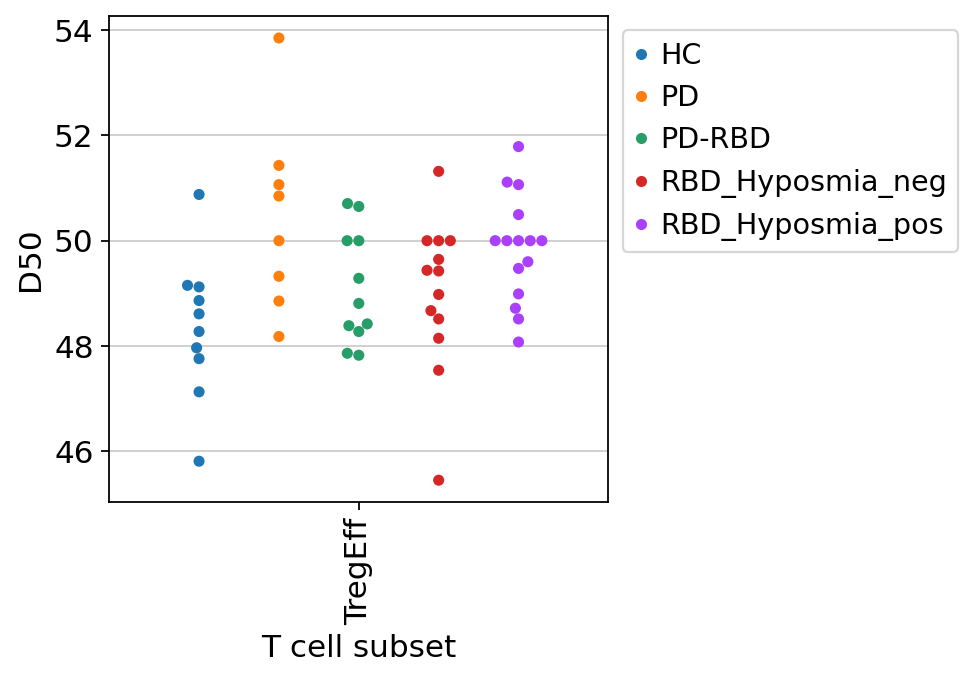

In [60]:
sns.swarmplot(data=df_diversity_tidy[df_diversity_tidy['T cell subset']=='TregEff'], 
    x='T cell subset', 
    y='D50', 
    hue='gex:Diagnosis_RBDstrat',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

## STARTRAC

In [61]:
df_startrac = mdata.obs[['tcr:clone_id', 'gex:DonorID', 'gex:CD4_clusterL2']].dropna()
df_startrac.columns = ['clone.id', 'patient', 'majorCluster']
df_startrac['loc'] = 'BLD'
df_startrac

clone.id patient majorCluster  loc
AAACGGGAGATCACGG-1-YPD001BLD        3  YPD001       Tnaive  BLD
AAAGATGAGACGCACA-1-YPD001BLD        5  YPD001       Tnaive  BLD
AAAGATGGTTAAAGTG-1-YPD001BLD        6  YPD001    TnaiveMX1  BLD
AAAGATGTCTGTTTGT-1-YPD001BLD        9  YPD001       Tnaive  BLD
AAAGCAAAGTGATCGG-1-YPD001BLD       12  YPD001    TnaiveAct  BLD
...                               ...     ...          ...  ...
TTTGGTTGTCGGGTCT-1-YPD097BLD   353824  YPD097       TcmTfh  BLD
TTTGTCAAGCGCTTAT-1-YPD097BLD   349321  YPD097       Tnaive  BLD
TTTGTCAGTATTCGTG-1-YPD097BLD   353827  YPD097   TnaiveSOX4  BLD
TTTGTCAGTCTAGTCA-1-YPD097BLD   353828  YPD097       Tnaive  BLD
TTTGTCATCGTCCGTT-1-YPD097BLD   351102  YPD097       TcmTh0  BLD

[197469 rows x 4 columns]

In [62]:
df_startrac.to_csv(f'../scanpy/{version}/startrac_input_CD4T.csv')

In [63]:
df_startrac = mdata.obs[['tcr:clone_id', 'gex:DonorID', 'gex:cluster_L2']].dropna()
df_startrac.columns = ['clone.id', 'patient', 'majorCluster']
df_startrac['loc'] = 'BLD'
df_startrac = df_startrac[df_startrac['majorCluster'].isin(list_tcell)]
df_startrac

clone.id patient  majorCluster  loc
AAACCTGAGTCCCACG-1-YPD001BLD        0  YPD001       CD8 Tem  BLD
AAACCTGCACGAGAGT-1-YPD001BLD        1  YPD001  CD8CD4 Temra  BLD
AAACCTGGTGAAGGCT-1-YPD001BLD        2  YPD001       CD8 Tem  BLD
AAACGGGAGATCACGG-1-YPD001BLD        3  YPD001          Treg  BLD
AAACGGGCAAGAGGCT-1-YPD001BLD        4  YPD001  CD8CD4 Temra  BLD
...                               ...     ...           ...  ...
TTTGGTTGTCGGGTCT-1-YPD097BLD   353824  YPD097       CD4 Tcm  BLD
TTTGTCAAGCGCTTAT-1-YPD097BLD   349321  YPD097    CD4 Tnaive  BLD
TTTGTCAGTATTCGTG-1-YPD097BLD   353827  YPD097       CD4 Tem  BLD
TTTGTCAGTCTAGTCA-1-YPD097BLD   353828  YPD097       CD4 Tcm  BLD
TTTGTCATCGTCCGTT-1-YPD097BLD   351102  YPD097       CD4 Tem  BLD

[258763 rows x 4 columns]

In [64]:
list_tcell

['CD8CD4 Temra',
 'CD8 Tem',
 'Treg',
 'CD4 Tcm',
 'CD4 Tem',
 'CD4 Tnaive',
 'CD8 Tnaive']

In [65]:
df_startrac = df_startrac[df_startrac['majorCluster'].isin(list_tcell)]

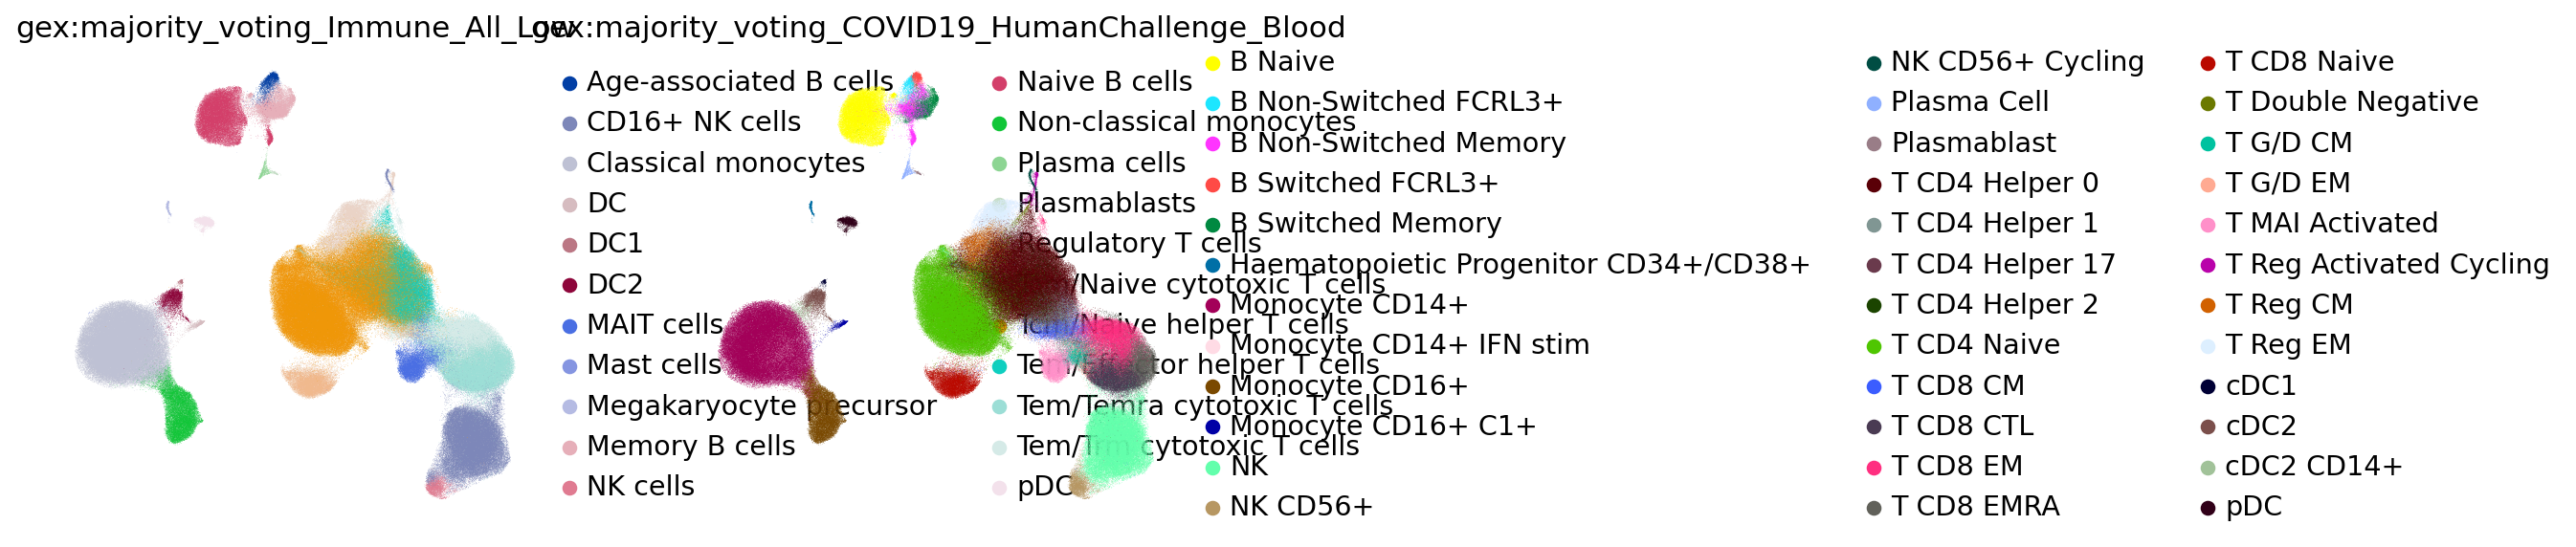

In [68]:
mu.pl.embedding(mdata, basis="gex:umap_filtered", 
    color=['gex:majority_voting_Immune_All_Low',
    'gex:majority_voting_COVID19_HumanChallenge_Blood'])

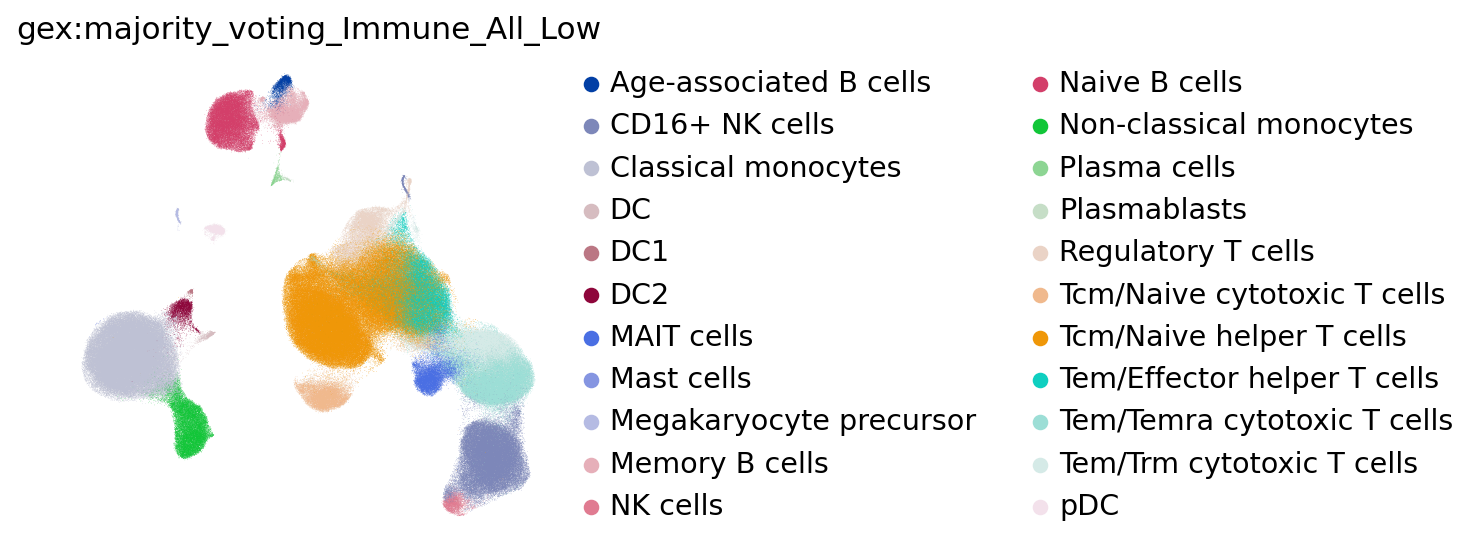

In [69]:
mu.pl.embedding(mdata, basis="gex:umap_filtered", 
    color=['gex:majority_voting_Immune_All_Low',])

In [70]:
list(mdata.obs['gex:majority_voting_Immune_All_Low'].unique())

['Tem/Temra cytotoxic T cells',
 'Classical monocytes',
 'CD16+ NK cells',
 'Tem/Trm cytotoxic T cells',
 'Memory B cells',
 'Naive B cells',
 'Non-classical monocytes',
 'Regulatory T cells',
 'Tcm/Naive helper T cells',
 'MAIT cells',
 'Plasma cells',
 'pDC',
 'DC2',
 'Tem/Effector helper T cells',
 'Age-associated B cells',
 'NK cells',
 'Tcm/Naive cytotoxic T cells',
 'Megakaryocyte precursor',
 'Mast cells',
 'DC1',
 'Plasmablasts',
 'DC',
 nan]

In [71]:
list_t_crosstissue = ['Tem/Temra cytotoxic T cells',
 'Tem/Trm cytotoxic T cells',
 'Regulatory T cells',
 'Tcm/Naive helper T cells',
 'Tem/Effector helper T cells',
 'Tcm/Naive cytotoxic T cells',]

In [72]:
df_startrac = mdata.obs[['tcr:clone_id', 'gex:DonorID', 'gex:majority_voting_Immune_All_Low']].dropna()
df_startrac.columns = ['clone.id', 'patient', 'majorCluster']
df_startrac['loc'] = 'BLD'
df_startrac = df_startrac[df_startrac['majorCluster'].isin(list_t_crosstissue)]
df_startrac.to_csv(f'../scanpy/{version}/startrac_input_T_crosstissue.csv')
df_startrac

clone.id patient                 majorCluster  \
AAACCTGAGTCCCACG-1-YPD001BLD        0  YPD001    Tem/Trm cytotoxic T cells   
AAACCTGCACGAGAGT-1-YPD001BLD        1  YPD001  Tem/Temra cytotoxic T cells   
AAACCTGGTGAAGGCT-1-YPD001BLD        2  YPD001    Tem/Trm cytotoxic T cells   
AAACGGGAGATCACGG-1-YPD001BLD        3  YPD001           Regulatory T cells   
AAACGGGCAAGAGGCT-1-YPD001BLD        4  YPD001  Tem/Temra cytotoxic T cells   
...                               ...     ...                          ...   
TTTGGTTGTCGGGTCT-1-YPD097BLD   353824  YPD097     Tcm/Naive helper T cells   
TTTGTCAAGCGCTTAT-1-YPD097BLD   349321  YPD097     Tcm/Naive helper T cells   
TTTGTCAGTATTCGTG-1-YPD097BLD   353827  YPD097     Tcm/Naive helper T cells   
TTTGTCAGTCTAGTCA-1-YPD097BLD   353828  YPD097     Tcm/Naive helper T cells   
TTTGTCATCGTCCGTT-1-YPD097BLD   351102  YPD097  Tem/Effector helper T cells   

                              loc  
AAACCTGAGTCCCACG-1-YPD001BLD  BLD  
AAACCTGCACGAGAGT-1-YPD001BLD  BLD  
AAACCTGGTGAAGGCT-1-YPD001BLD  BLD  
AAACGGGAGATCACGG-1-YPD001BLD  BLD  
AAACGGGCAAGAGGCT-1-YPD001BLD  BLD  
...                           ...  
TTTGGTTGTCGGGTCT-1-YPD097BLD  BLD  
TTTGTCAAGCGCTTAT-1-YPD097BLD  BLD  
TTTGTCAGTATTCGTG-1-YPD097BLD  BLD  
TTTGTCAGTCTAGTCA-1-YPD097BLD  BLD  
TTTGTCATCGTCCGTT-1-YPD097BLD  BLD  

[259055 rows x 4 columns]